In [4]:
from Bio.PDB import PDBParser
import networkx as nx

class Protein:
    def __init__(self, fileName, thresh):
        self.pdbFile = fileName
        self.eThresh = thresh
        self.struct = self.getStruct(self.pdbFile)
        self.graph, self.layers = \
            self.genGraph(self.struct, self.eThresh)
        
    def getStruct(self, pdbFile):
        parser = PDBParser(QUIET=True)
        structure = \
            parser.get_structure("protein", pdbFile)
        return(structure)
        
    def genGraph(self, structure, eThresh):
        nodes, layers = [], []
        for model in structure:
            for chain in model:
                atoms = []
                for residue in chain:
                    for atom in residue:
                        if atom.name=="CA":
                            atoms.append(atom)
                if len(atoms):
                    nodes.extend(atoms)
                    layers.append(len(atoms))
        edges = []
        for i in range(len(nodes)-1):
            for j in range(i+1, len(nodes)):
                dist = nodes[i]-nodes[j]
                if dist>0. and dist<=eThresh:
                    edges.append((i,j))
        g = nx.Graph(edges)
        return(g, layers)

    def getGraph(self):
        return(self.graph, self.layers)

In [5]:
import numpy as np

class MultiCens:
    # implementation based on original MultiCens
    def __init__(self, g, layers, p, nIter):
        self.nodes = list(g.nodes())
        self.nodes.sort()
        self.edges = list(g.edges())
        self.layers = layers
        self.p = p
        self.nIter = nIter
        self.a, self.c = \
            self.getAdjMat(self.edges, self.layers)
        self.gc = self.computeGlobal()

    def getAdjMat(self, edges, layers):
        l1, l2 = layers[0], layers[1]
        adj = np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            adj[u, v] = 1.
            adj[v, u] = 1.
        adj = adj / np.sum(adj, axis=0)
        a, c = np.zeros(shape=(l1+l2, l1+l2)), \
                        np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            if (u<l1 and v<l1) or (u>=l1 and v>=l1):
                a[u, v] = adj[u, v]
                a[v, u] = adj[v, u]
            elif (u<l1 and v>=l1) or (v<l1 and u>=l1):
                c[u, v] = adj[u, v]
                c[v, u] = adj[v, u]
        return(a, c)
    
    def unitVector(self, vector):
        return(vector/np.linalg.norm(vector))
    
    def angleBetween(self, v1, v2):
        v1_u = self.unitVector(v1)
        v2_u = self.unitVector(v2)
        return(np.arccos(np.clip( \
                np.dot(v1_u, v2_u), -1.0, 1.0)))
    
    def computeLocal(self):
        n = self.a.shape[0]
        l = np.ones(n) / n
        unitNormal = np.copy(l)
        angle = float(0)
        for _ in range(self.nIter):
            lNew = (self.p*(self.a.dot(l))) + \
                            ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(l, lNew)
            if (angleNew==angle) or (angleNew==0):
                break
            l, angle = lNew, angleNew
        return(l)
    
    def computeGlobal(self):
        l = self.computeLocal()
        n = self.a.shape[0]
        g = np.ones(n) / n
        unitNormal = np.copy(g)
        angle = float(0)
        for _ in range(self.nIter):
            gNew = (self.p*((self.a+self.c).dot(g) + \
                self.c.dot(l))) + ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(g, gNew)
            if (angleNew==angle) or (angleNew==0):
                break
            g, angle = gNew, angleNew
        return(g)

    def getMultiCens(self):
        mc = (self.gc-self.gc.min()) /  \
                       (self.gc.max()-self.gc.min())
        mc = {x:mc[x] for x in self.nodes}
        return(mc)

In [795]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
from networkx.algorithms.community import greedy_modularity_communities

# class MultiLayerCentrality:
    
def compMLModularity(g, layer1, layer2, gamma=1, omega=1):
    layer1 = [x for x in layer1.nodes()]
    layer1.sort()
    layer2 = [x for x in layer2.nodes()]
    layer2.sort()
    # a = self.a+self.c
    a = nx.adjacency_matrix(g).todense()
    m = a.sum() / 2  
    commu = list(greedy_modularity_communities(g))
    commuMap = {node: i for i,com in enumerate(commu) for node in com}
    mod = {i: 0 for i in range(len(a))}  

    for i in range(len(a)):
        for j in range(len(a)):
            same = commuMap[i] == commuMap[j]
            intra = (i in layer1 and j in layer1) or (i in layer2 and j in layer2)
            inter = (i in layer1 and j in layer2) or (i in layer2 and j in layer1)
            ki = a[i].sum()
            kj = a[j].sum()
    
            if intra:
                contrib = (a[i, j] - gamma * (ki * kj / (2 * m))) * same
                mod[i] += contrib  
                mod[j] += contrib  
    
            elif inter:
                contrib = omega * a[i, j] * same
                mod[i] += contrib  
                mod[j] += contrib  
    
    return(mod)

# def compute_node_metric(g, layer1, layer2, alpha=.000000000001, beta=2.11111111111, gamma=.555555555555, top_k=5, gamma_mod=1, omega_mod=1):
def compute_node_metric(g, layer1, layer2, alpha=0, beta=1, gamma=0, top_k=5, gamma_mod=1, omega_mod=1):
    
    nodes = list(g.nodes())
    nodes.sort()
    # Step 3: Compute spectral embedding for the entire graph g
    def compute_laplacian_eigenvectors(graph, k):
        """Compute the top k eigenvectors of the normalized Laplacian."""
        L = nx.normalized_laplacian_matrix(graph)
        eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')
        return eigenvectors

    spectral_g = compute_laplacian_eigenvectors(g, top_k)  # Spectral embedding for the entire graph g

    # Step 4: Compute spectral alignment S(v) for each node
    spectral_alignment = {}
    node_to_index_g = {node: idx for idx, node in enumerate(nodes)}

    for node in nodes:
        idx_g = node_to_index_g[node]
        vec_g = spectral_g[idx_g]

        # Align the node from both layers (layer1 and layer2)
        vec_layer1 = np.zeros(top_k) if node not in layer1 else spectral_g[node_to_index_g[node]]
        vec_layer2 = np.zeros(top_k) if node not in layer2 else spectral_g[node_to_index_g[node]]
        
        # Compute the spectral alignment
        alignment_layer1 = np.linalg.norm(vec_layer1 - vec_g) ** 2
        alignment_layer2 = np.linalg.norm(vec_layer2 - vec_g) ** 2
        spectral_alignment[node] = alignment_layer1 + alignment_layer2

    # Step 5: Normalize modularity scores Q'(v)
    modularity_scores = compMLModularity(g, layer1, layer2, gamma_mod, omega_mod)
    max_modularity = max(modularity_scores.values())
    normalized_modularity = {node: modularity_scores.get(node, 0) / max_modularity for node in nodes}

    # # Step 6: Compute interdependence factor (coupling strength) between layers
    # interdependence_factor = {}
    # for node in nodes:
    #     if node in layer1 and node in layer2:
    #         degree_layer1 = layer1.degree[node]
    #         degree_layer2 = layer2.degree[node]
    #         interdependence_factor[node] = omega_mod * abs(degree_layer1 - degree_layer2)
    #     else:
    #         interdependence_factor[node] = 0

    # Step 6: Compute interdependence factor (coupling strength) between layers
    interdependence_factor = {}
    # Create a combined graph to analyze interlayer and intralayer edges
    for node in g.nodes():
        # Intralayer neighbors
        neighbors_intralayer = set()
        if node in layer1:
            neighbors_intralayer = set(layer1.neighbors(node))
        elif node in layer2:
            neighbors_intralayer = set(layer2.neighbors(node))
        
        # Interlayer neighbors
        neighbors_interlayer = set(g.neighbors(node)) - neighbors_intralayer
    
        # Edge Overlap
        overlap = len(neighbors_intralayer & neighbors_interlayer) / len(neighbors_intralayer | neighbors_interlayer) if neighbors_intralayer | neighbors_interlayer else 0
    
        # Neighborhood Similarity
        vector_intralayer = np.array([1 if neighbor in neighbors_intralayer else 0 for neighbor in g.nodes()])
        vector_interlayer = np.array([1 if neighbor in neighbors_interlayer else 0 for neighbor in g.nodes()])
        similarity = np.dot(vector_intralayer, vector_interlayer) / (np.linalg.norm(vector_intralayer) * np.linalg.norm(vector_interlayer)) if np.linalg.norm(vector_intralayer) * np.linalg.norm(vector_interlayer) > 0 else 0
    
        # Combine metrics for interdependence
    interdependence_factor[node] = omega_mod * (4.555555555555 * overlap + .444444444444 * similarity)

    # Step 7: Combine spectral alignment, modularity, and interdependence into M(v)
    node_metrics = {}
    for node in nodes:
        S_v = spectral_alignment.get(node, 0)
        Q_v = normalized_modularity.get(node, 0)
        phi_v = interdependence_factor.get(node, 0)
        node_metrics[node] = alpha * S_v + beta * Q_v + gamma * phi_v

    mlc = np.array([node_metrics[x] for x in nodes])
    mlc = (mlc - mlc.min()) / (mlc.max() - mlc.min())
    # print(mc)
    mlc = {x:mlc[x] for x in nodes}
    return mlc

In [6]:
import random
import networkx as nx
import numpy as np
import seaborn as sns
from scipy.stats import wasserstein_distance
from matplotlib.colors import LinearSegmentedColormap

class RandomInterlayer:
    def __init__(self, g, layers):
        self.g = g
        self.layers = layers
        self.layer1 = \
                set(i for i in range(layers[0]))
        self.layer2 = set(i for i in \
                range(layers[0], layers[0]+layers[1]))
        self.interlayer = \
            [(u, v) for u, v in self.g.edges() \
            if (u in self.layer1 and v in self.layer2) \
            or (v in self.layer1 and u in self.layer2)]
        
        self.normInter = {tuple(sorted(edge)) for edge in self.interlayer}
        
        self.layer1Inter, self.layer2Inter = \
                            self.getInterlayerNodes()
        self.nInter = len(self.interlayer)
        self.choices = \
            [(u, v) for u in self.layer1 for v in self.layer2]
        self.newG = self.g.copy()
        self.newG.remove_edges_from(self.interlayer)
        nodesNewG = list(self.newG.nodes())
        nodesNewG.sort()
        # print(self.interlayer)
        print(len(list(self.newG.edges())))
        print(len(list(self.g.edges())))
        for u,v in self.newG.edges():
            if (u in self.layer1 and v in self.layer2) or \
                (v in self.layer1 and u in self.layer2):
                print("INTER1:",u,v)
        adj = nx.adjacency_matrix(self.newG, nodelist=nodesNewG).todense()
        # nodes = list(self.newG.nodes())
        print(len(adj),len(adj[0]))
        for r in range(len(adj)):
            for c in range(len(adj)):
                # nodeR, nodeC = nodes[r], nodes[c]
                if ((r in self.layer1 and c in self.layer2) or \
                    (c in self.layer1 and r in self.layer2)) and \
                    adj[r][c]:
                        print("INTER2:",r,c)

    def getInterlayerNodes(self):
        layer1Inter, layer2Inter = set(), set()
        for u,v in self.interlayer:
            if u in self.layer1:
                layer1Inter.add(u)
            if v in self.layer1:
                layer1Inter.add(v)
            if u in self.layer2:
                layer2Inter.add(v)
            if v in self.layer2:
                layer2Inter.add(v)
        # print("layer1Inter",layer1Inter)
        # print("layer2Inter",layer2Inter)
        return(layer1Inter, layer2Inter)
    
    def genRandom(self, seed=42):
        random.seed(seed)
        newInterlayer = \
                random.sample(self.choices, self.nInter)
        
        normNewInter = {tuple(sorted(edge)) for edge in newInterlayer}
        overlap = self.normInter & normNewInter
        overlapCount = len(overlap)
        print("Gen Random: overlap count:",overlapCount)
        
        newG = self.newG.copy()
        newG.add_edges_from(newInterlayer)
        return(newG)

    def genRandWithSP1(self, seed=42):
        interlayerSP = []
        sps = \
            dict(nx.all_pairs_shortest_path_length(self.g))
        for u in self.layer1:
            for v in self.layer2:
                interlayerSP.append(sps[u].get(v))
        thresh = np.percentile(interlayerSP, \
                                   [25, 50, 75, 90])[2]
        choices = [(u, v) for (u,v) in self.choices \
                        if sps.get(u).get(v) <= thresh]
        random.seed(seed)
        newInterlayer = \
                random.sample(choices, self.nInter)

        normNewInter = {tuple(sorted(edge)) for edge in newInterlayer}
        overlap = self.normInter & normNewInter
        overlapCount = len(overlap)
        print("Gen Random with SP1: overlap count:",overlapCount)
        
        newG = self.newG.copy()
        newG.add_edges_from(newInterlayer)
        return(newG)

    def getRandSubsets(self, trail):
        random.seed(trail)
        # print(len(self.layer1Inter),len(self.layer2Inter))
        layer1InterRd = random.sample( \
                list(self.layer1), len(self.layer1Inter))
        layer2InterRd = random.sample( \
                list(self.layer2), len(self.layer2Inter))
        # print("layer1InterRd",layer1InterRd)
        # print("layer2InterRd",layer2InterRd)
        return(layer1InterRd, layer2InterRd)

    def getSPLens(self, layer1, layer2, g):
        sps = \
            dict(nx.all_pairs_shortest_path_length(g))
        pLens = []
        for u in self.layer1:
            for v in self.layer2:
                pLens.append(sps[u].get(v))
        return(pLens)

    def getSimilarity(self, original, new):
        d = wasserstein_distance(original, new)
        s = 1. / (1.+d)
        return(s)

    def plotOrigNew(self, original, new):
        wd = wasserstein_distance(original, new)
        plt.figure(figsize=(10, 10))
        plt.hist(original, bins=50, alpha=0.6, label="Original Distribution", density=True)
        plt.hist(new, bins=50, alpha=0.6, label="New Distribution", density=True)
        plt.title(f"Wasserstein Distance: {wd:.4f}", fontsize=14)
        plt.xlabel("Value", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.legend(fontsize=12)
        plt.show()

    def genRandWithSP2(self, seed=42, maxTrials=1, flag=0):
        spLens = self.getSPLens(self.layer1Inter, \
                                    self.layer2Inter, self.g)
        newInterlayer = []
        bestScore = float('-inf')
        newG = self.newG.copy()
        spDistri = []
        for trial1 in range(maxTrials):
            print("Trial",trial1+1, \
                ": gen rand graph with closest SP distri.")
            l1Inter, l2Inter = self.getRandSubsets(trial1)
            choices = \
                [(u, v) for u in l1Inter for v in l2Inter]
            for trial2 in range(maxTrials):
                random.seed(trial2)
                newIL = random.sample(choices, self.nInter)

                normNewInter = {tuple(sorted(edge)) for edge in newIL}
                overlap = self.normInter & normNewInter
                overlapCount = len(overlap)
                print("Gen Random with SP2: overlap count:",overlapCount)
                
                newG.add_edges_from(newIL)
                newSPLens = self.getSPLens( \
                                    l1Inter, l2Inter, newG)
                score = self.getSimilarity(spLens, newSPLens)
                spDistri.append(score)
                if score>bestScore:
                    self.plotOrigNew(spLens, newSPLens)
                    bestScore = score
                    newInterlayer = newIL
                    if flag: self.plotAdjDiff(newG)
                newG.remove_edges_from(newIL)
        newG.add_edges_from(newInterlayer)
        if flag:
            self.plotSPDistr(spDistri)
        return(newG)

    def plotSPDistr(self, d):
        plt.figure(figsize=(10, 10))
        plt.plot(range(1, len(d)+1), d, marker='o', color='blue')
        plt.xlabel('Iteration')
        plt.ylabel('SP Distri Similarity to Original')
        plt.title('Shortest Path Distri Similarity')
        plt.legend()
        plt.show()

    def plotAdj(self):
        nodes = list(self.g.nodes())
        nodes.sort()
        adj = nx.adjacency_matrix(self.g, nodelist=nodes).todense()
        plt.figure(figsize=(10, 10))
        colors = ['white', 'blue']
        cmap = LinearSegmentedColormap.from_list( \
                            'custom_cmap', colors, N=256)
        plt.imshow(adj, cmap=cmap, \
                           interpolation="nearest")
        plt.colorbar()
        plt.title(f"Adj: {len(remove) \
                if remove else 'No'} nodes removed")
        plt.show()
        
    def plotAdjDiff(self, g, remove=None):
        nodes = list(self.g.nodes())
        nodes.sort()
        adj = nx.adjacency_matrix(g, nodelist=nodes).todense() - nx.adjacency_matrix(self.g, nodelist=nodes).todense()
        plt.figure(figsize=(10, 10))
        colors = ['red', 'white', 'blue']
        cmap = LinearSegmentedColormap.from_list( \
                            'custom_cmap', colors, N=256)
        plt.imshow(adj, cmap=cmap, \
                           interpolation="nearest")
        plt.colorbar()
        plt.title(f"Adj: {len(remove) \
                if remove else 'No'} nodes removed")
        plt.show()
    
    def getRand(self):
        return(self.genRandom())

    def getRandTopo(self):
        return(self.genRandWithSP1(), self.genRandWithSP2(self, maxTrials=10))

In [71]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy.interpolate import interp1d
from networkx.algorithms.community import modularity, greedy_modularity_communities
from scipy.stats import gaussian_kde

class CompareContrast(MultiCens):
    def __init__(self, g, layers, p, nIter):
        super().__init__(g, layers, p, nIter)
        self.g = g
        self.layer1 = \
                set(i for i in range(layers[0]))
        self.layer2 = set(i for i in \
                range(layers[0], layers[0]+layers[1]))
        self.inter = set()
        for u, v in self.g.edges():
            if (u in self.layer1 and v in self.layer2) or \
                    (v in self.layer1 and u in self.layer2):
                self.inter.add(u)
                self.inter.add(v)
        self.interlayer = \
            [(u, v) for u, v in self.g.edges() \
            if (u in self.layer1 and v in self.layer2) \
            or (v in self.layer1 and u in self.layer2)]
        self.l1g = self.g.subgraph([i for i in range(layers[0])])
        self.l2g = self.g.subgraph([i for i in range(layers[0],layers[0]+layers[1])])
        self.m = self.getMultiCens()
        # self.m = compute_node_metric(self.g, self.l1g, self.l2g)
        self.e = self.compEVC(self.g)
        self.el1 = self.compEVC(self.l1g)
        self.el2 = self.compEVC(self.l2g)

    def compEVC(self, g):
        nodes = sorted(list(g.nodes()))
        e = nx.eigenvector_centrality(g, max_iter=1000, tol=1e-6)
        mn, mx = min(e.values()), max(e.values())
        e = {k:(v-mn)/(mx-mn) for k,v in e.items()}
        return(e)

    def compNodeModularity(self, g):
        nodes = sorted(list(g.nodes()))
        commu = list(greedy_modularity_communities(g))
        commuMap = {node: i for i,com in enumerate(commu) for node in com}
        m = g.size(weight='weight')  # Total number of edges
        mod = {}
        for u in nodes:
            commuU = commuMap[u]
            ku = g.degree(u, weight='weight')
            modContri = 0
            for v in nodes:
                if u!=v:
                    if commuMap[v]==commuU:
                        kv = g.degree(v, weight='weight')
                        aUV = 1 if g.has_edge(u, v) else 0
                        modContri += aUV - (ku * kv) / (2 * m)
            mod[u] = modContri / (2 * m)
        return(mod)
    
    def compMLModularity(self, gamma=1, omega=1):
        a = self.a+self.c
        m = (self.a+self.c).sum() / 2  
        commu = list(greedy_modularity_communities(self.g))
        commuMap = {node: i for i,com in enumerate(commu) for node in com}
        mod = {i: 0 for i in range(len(a))}  
    
        for i in range(len(a)):
            for j in range(len(a)):
                same = commuMap[i] == commuMap[j]
                intra = (i in self.layer1 and j in self.layer1) or (i in self.layer2 and j in self.layer2)
                inter = (i in self.layer1 and j in self.layer2) or (i in self.layer2 and j in self.layer1)
                ki = a[i].sum()
                kj = a[j].sum()
        
                if intra:
                    contrib = (a[i, j] - gamma * (ki * kj / (2 * m))) * same
                    mod[i] += contrib  
                    mod[j] += contrib  
        
                elif inter:
                    contrib = omega * a[i, j] * same
                    mod[i] += contrib  
                    mod[j] += contrib  
        
        return(mod)

    def plotMLModVCen(self):
        mod = self.compMLModularity()
        nodes = sorted(list(self.g.nodes()))
        intraMod = [mod[n] for n in nodes if n not in self.inter]
        interMod = [mod[n] for n in nodes if n in self.inter]
        intraM = [self.m[n] for n in nodes if n not in self.inter]
        interM = [self.m[n] for n in nodes if n in self.inter]
        intraE = [self.e[n] for n in nodes if n not in self.inter]
        interE = [self.e[n] for n in nodes if n in self.inter]
        
        plt.figure(figsize=(14, 10))
        plt.scatter(intraMod, intraM, label="Intra Multicens", alpha=0.7)
        plt.scatter(intraMod, intraE, label="Intra EV", alpha=0.7)
        plt.scatter(interMod, interM, label="Inter Multicens", alpha=0.7)
        plt.scatter(interMod, interE, label="Inter EV", alpha=0.7)
        plt.xlabel("ML Node Modularity", fontsize=30)
        plt.ylabel("Centrality", fontsize=30)
        plt.xticks(fontsize=30, rotation=45)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        plt.savefig("fig6", dpi=300, bbox_inches='tight')
        plt.show()
            
    def plotModVCen(self):
        nodes = sorted(list(self.g.nodes()))
        mod = self.compNodeModularity(self.g)
        mod = [mod[node] for node in nodes]
        cen1 = [self.e[node] for node in nodes]
        cen2 = [self.m[node] for node in nodes]
        plt.figure(figsize=(14, 10))
        plt.scatter(mod, cen1, label="Eigenvector Centrality", alpha=0.7)
        plt.scatter(mod, cen2, label="Multicens Centrality", alpha=0.7)
        plt.xlabel("Node Modularity Contribution", fontsize=30)
        plt.ylabel("Centrality", fontsize=30)
        plt.xticks(fontsize=30, rotation=45)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        plt.savefig("fig1", dpi=300, bbox_inches='tight')
        plt.show()

    def plotIntraModVCen(self):
        mod1 = self.compNodeModularity(self.l1g)
        nodes = sorted(list(self.l1g.nodes()))
        mod1 = [mod1[node] for node in nodes]
        cen1 = [self.el1[node] for node in nodes]
        mod2 = self.compNodeModularity(self.l2g)
        nodes = sorted(list(self.l2g.nodes()))
        mod2 = [mod2[node] for node in nodes]
        cen2 = [self.el2[node] for node in nodes]
        print(len(mod1),len(cen1),len(mod2),len(cen2))
        plt.figure(figsize=(14, 10))
        plt.scatter(mod1, cen1, label="Layer 1", alpha=0.7)
        plt.scatter(mod2, cen2, label="Layer 2", alpha=0.7)
        plt.xlabel("Node Modularity Contribution", fontsize=30)
        plt.ylabel("EV Centrality", fontsize=30)
        plt.xticks(fontsize=30, rotation=45)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        plt.savefig("fig2", dpi=300, bbox_inches='tight')
        plt.show()

    def getInterp1d(self, v1, v2):
        v1, v2 = np.array(v1), np.array(v2)
        v1 = (v1-v1.min()) / (v1.max()-v1.min())
        v2 = (v2-v2.min()) / (v2.max()-v2.min())
        x = np.linspace(0, 1, len(v2))
        f = interp1d(x, np.array(v2), kind='linear', fill_value='extrapolate')
        v2 = f(np.linspace(0, 1, len(v1)))
        return(v1,v2)
    
    def plotDependence(self):
        mod1 = self.compNodeModularity(self.l1g)
        nodes = sorted(list(self.l1g.nodes()))
        mod1 = [mod1[node] for node in nodes]
        cen1 = [self.el1[node] for node in nodes]
        mod2 = self.compNodeModularity(self.l2g)
        nodes = sorted(list(self.l2g.nodes()))
        mod2 = [mod2[node] for node in nodes ]
        cen2 = [self.el2[node] for node in nodes]
        intraMod = mod1+mod2
        intraE = cen1+cen2
        # print(len(self.inter))
        # print(len(mod1),len(mod2),len(cen1),len(cen2))
        # print(nodes)
        # print(self.inter)
        
        mod = self.compNodeModularity(self.g)
        nodes = sorted(list(self.g.nodes()))
        interM, intraM, interE, interMod = [], [], [], []
        for node in nodes:
            if node in self.inter:
                interM.append(self.m[node])
                interE.append(self.e[node])
                interMod.append(mod[node])
            else:
                intraM.append(self.m[node])

        # print(len(intraMod),len(interMod),len(intraE),len(interE),len(intraM),len(interM))
        intraMod, interMod = self.getInterp1d(intraMod, interMod)
        intraE, interE = self.getInterp1d(intraE, interE)
        intraM, interM = self.getInterp1d(intraM, interM)

        data1 = np.vstack([intraMod, interMod]).T
        pca = PCA(n_components=2)
        pca1 = pca.fit_transform(data1)
        data2 = np.vstack([intraE, interE]).T
        pca2 = pca.fit_transform(data2)
        data3 = np.vstack([intraM, interM]).T
        pca3 = pca.fit_transform(data3)

        plt.figure(figsize=(10, 10))
        plt.scatter(pca1[:,0], pca1[:,1], label="Modularity", alpha=0.7)
        plt.scatter(pca2[:,0], pca2[:,1], label="Eigenvector Centrality", alpha=0.7)
        plt.scatter(pca3[:,0], pca3[:,1], label="Multicens Centrality", alpha=0.7)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend()
        plt.show()

        data1 = np.vstack([intraMod, interMod]).T
        umapp = umap.UMAP(n_components=2)
        umap1 = umapp.fit_transform(data1)
        data2 = np.vstack([intraE, interE]).T
        umap2 = umapp.fit_transform(data2)
        data3 = np.vstack([intraM, interM]).T
        umap3 = umapp.fit_transform(data3)

        plt.figure(figsize=(10, 10))
        plt.scatter(umap1[:,0], umap1[:,1], label="Modularity", alpha=0.7)
        plt.scatter(umap2[:,0], umap2[:,1], label="Eigenvector Centrality", alpha=0.7)
        plt.scatter(umap3[:,0], umap3[:,1], label="Multicens Centrality", alpha=0.7)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.legend()
        plt.show()

    def compMod(self, g):
        comm = list(greedy_modularity_communities(g))
        return(modularity(g, comm), comm)
    
    def compInterMod(self, commuL1, commuL2):
        interlayerContr = 0
        for u, v in self.interlayer:
            
            commLayer1 = next((i for i, comm in enumerate(commuL1) if u in comm), None)
            commLayer2 = next((i for i, comm in enumerate(commuL2) if v in comm), None)
            
            if commLayer1 == commLayer2:
                interlayerContr += 1
    
        return(interlayerContr/len(self.interlayer))
    
    def calcTotalMod(self):
        modL1, commuL1 = self.compMod(self.l1g)
        modL2, commuL2 = self.compMod(self.l2g)
        mod, commu = self.compMod(self.g)
        
        interContri = self.compInterMod(commuL1, commuL2)
        
        totalMod = (modL1 + modL2) / 2 + interContri
        print(f"Intralayer Modularity (Layer 1): {modL1}")
        print(f"Intralayer Modularity (Layer 2): {modL2}")
        print(f"Interlayer Modularity Contribution: {interContri}")
        print(f"Total Modularity (with interlayer contribution): {totalMod}")
        print(f"Total Modularity: {mod}")

    def plotModCompari(self):
        
        commL1 = list(greedy_modularity_communities(self.l1g))
        commL2 = list(greedy_modularity_communities(self.l2g))
        comm = list(greedy_modularity_communities(self.g))
    
        colmapL1 = {node: idx for idx, comm in enumerate(commL1) for node in comm}
        colmapL2 = {node: idx for idx, comm in enumerate(commL2) for node in comm}
        colmap = {node: idx for idx, comm in enumerate(comm) for node in comm}
    
        posL1 = nx.spring_layout(self.l1g, seed=42)
        offset = [2, 0]  # Define the offset (move the graph to the right)
        posL2 = nx.spring_layout(self.l2g, seed=42)  # Seed for consistency
        posL2 = {node: (x + offset[0], y + offset[1]) for node, (x, y) in posL2.items()}
    
        plt.figure(figsize=(14, 10))
    
        plt.subplot(131)  
        nx.draw(self.l1g, pos=posL1, with_labels=False, node_size=500, 
                node_color=[colmapL1[node] for node in self.l1g.nodes()], cmap=plt.cm.rainbow, edge_color='b')
        plt.title("Layer 1 - Community Structure")

        nx.draw(self.l2g, pos=posL2, with_labels=False, node_size=500, 
                node_color=[colmapL2[node] for node in self.l2g.nodes()], cmap=plt.cm.rainbow, edge_color='g')
        plt.title("Layer 2 - Community Structure")
        
        for u, v in self.interlayer:
            if u in posL1 and v in posL2:
                pos1, pos2 = posL1[u], posL2[v]
                plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'k--', alpha=0.5) 
            
        plt.title("Combined Graph with Interlayer Connections")
        
        plt.tight_layout()
        plt.savefig("fig7", dpi=300, bbox_inches='tight')
        plt.show()


    def plotStrTiesBridges(self):
        comm = list(greedy_modularity_communities(self.g))
        commMap = {node: idx for idx, com in enumerate(comm) for node in com}
        
        strongTies = [edge for edge in self.g.edges if commMap[edge[0]] == commMap[edge[1]]]
        bridges = [edge for edge in self.g.edges if commMap[edge[0]] != commMap[edge[1]]]
        nodes = sorted(list(self.g.nodes()))
        
        strongTieNodes = {n for edge in strongTies for n in edge}
        bridgeNodes = {n for edge in bridges for n in edge}
        
        plt.figure(figsize=(20, 10))
        
        plt.subplot(121)
        plt.scatter(
            [self.e[n] for n in strongTieNodes],
            [self.m[n] for n in strongTieNodes],
            c='blue', alpha=0.7, label="Strong Ties"
        )
        plt.xlabel("Eigenvector Centrality", fontsize=30)
        plt.ylabel("Multilayer Centrality", fontsize=30)
        plt.title("Nodes in Strong Ties", fontsize=30)
        plt.xticks(fontsize=30, rotation=45)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        
        plt.subplot(122)
        plt.scatter(
            [self.e[n] for n in bridgeNodes],
            [self.m[n] for n in bridgeNodes],
            c='red', alpha=0.7, label="Bridges"
        )
        plt.xlabel("Eigenvector Centrality", fontsize=30)
        plt.ylabel("Multilayer Centrality", fontsize=30)
        plt.title("Nodes in Bridges", fontsize=30)
        plt.xticks(fontsize=30, rotation=45)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        
        plt.tight_layout()
        plt.savefig("fig12", dpi=300, bbox_inches='tight')
        plt.show()

    def getLapSpec(self, g, normalize=True):
        l = nx.laplacian_matrix(g).toarray()
        evs = np.linalg.eigvals(l)
        evs = np.sort(np.real(evs))
        if normalize:
            return(evs/max(evs))
        return(evs)
        
    def plotSpectralProperties(self):
        eL1 = self.getLapSpec(self.l1g)
        eL2 = self.getLapSpec(self.l2g)
        eg = self.getLapSpec(self.g)
        
        
        plt.figure(figsize=(14, 10))
        
        for evs, label, color in zip(
            [eL1, eL2, eg],
            ["Layer 1", "Layer 2", "Entire graph"],
            ['blue', 'green', 'red']
        ):
            
            kde = gaussian_kde(evs)
            xVals = np.linspace(min(evs), max(evs), 500)
            plt.plot(xVals, kde(xVals), label=label, color=color, alpha=0.8)
        
        plt.xlabel("Normalized Eigenvalue", fontsize=30)
        plt.ylabel("Density", fontsize=30)
        plt.title("Laplacian Eigenvalue Spectrum Comparison (Normalized)", fontsize=30)
        plt.xticks(fontsize=30, rotation=45)
        plt.yticks(fontsize=30)
        plt.legend(fontsize=30)
        plt.savefig("fig16", dpi=300, bbox_inches='tight')
        plt.show()

In [124]:
import pandas as pd

def compareRankings(layers, g, ec, mc):
    l1, l2 = layers[0], layers[1]
    interNodes = set()
    for u,v in g.edges():
        if u<l1 and v>=l1 or \
            v<l1 and u>=l1:
            interNodes.add(u)
            interNodes.add(v)
            
    plt.figure(figsize=(10, 10))
    df = pd.DataFrame({
        'node': [i for i in range(l1+l2)],
        'ec': ec,
        'mc': mc
    })
    df['ecRank'] = df['ec'].rank(ascending=False)
    df['mcRank'] = df['mc'].rank(ascending=False)
    for i, row in df.iterrows():
        if row['node'] in interNodes:
            plt.scatter(row['mcRank'], row['ecRank'], \
                        s=100, color='red', marker='D')
        else:
            plt.scatter(row['mcRank'], row['ecRank'], \
                        s=100, color='blue', marker='o')
    plt.scatter([], [], s=100, color='red', \
                marker='D', label='Inter-layer Node')
    plt.scatter([], [], s=100, color='blue', \
                marker='o', label='Intra-layer Node')
    plt.xlabel('Multicens Centrality Rank')
    plt.ylabel('Eigenvector Centrality Rank')
    # for i, row in centrality_df.iterrows():
        # plt.annotate(row['node'], (row['mcRank'], \
                    # row['ecRank']), fontsize=8)
    plt.axline((0, 0), slope=1, \
               color='grey', linestyle='--')
    plt.grid()
    plt.legend()
    plt.show()

2642
2718
728 728
Gen Random with SP1: overlap count: 0
Trial 1 : gen rand graph with closest SP distri.
Gen Random with SP2: overlap count: 0


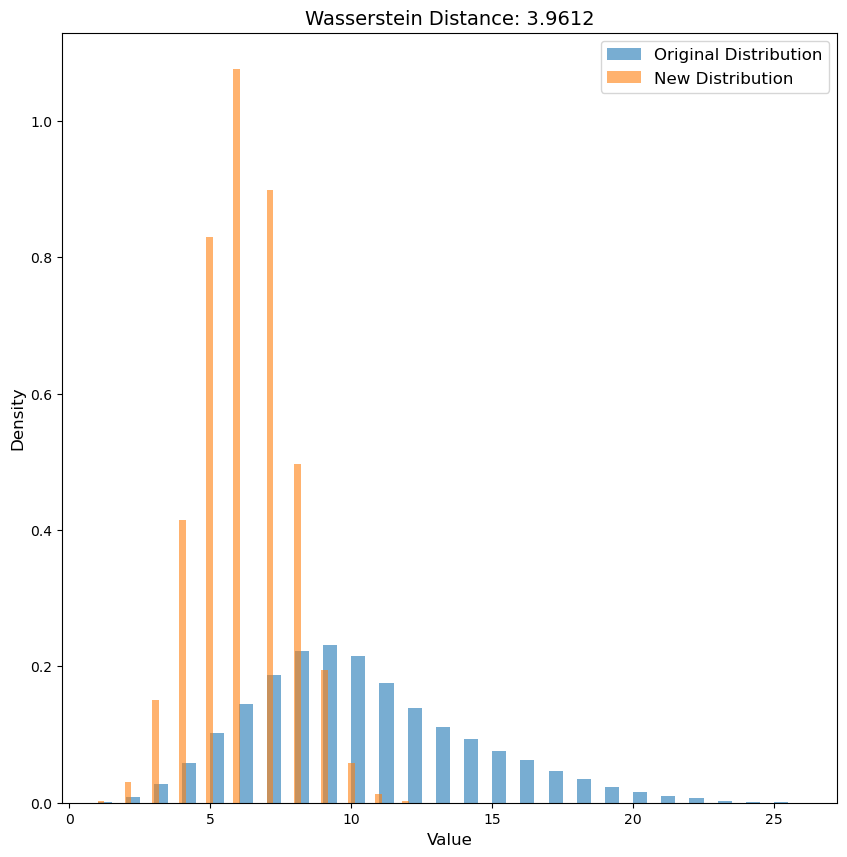

Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0


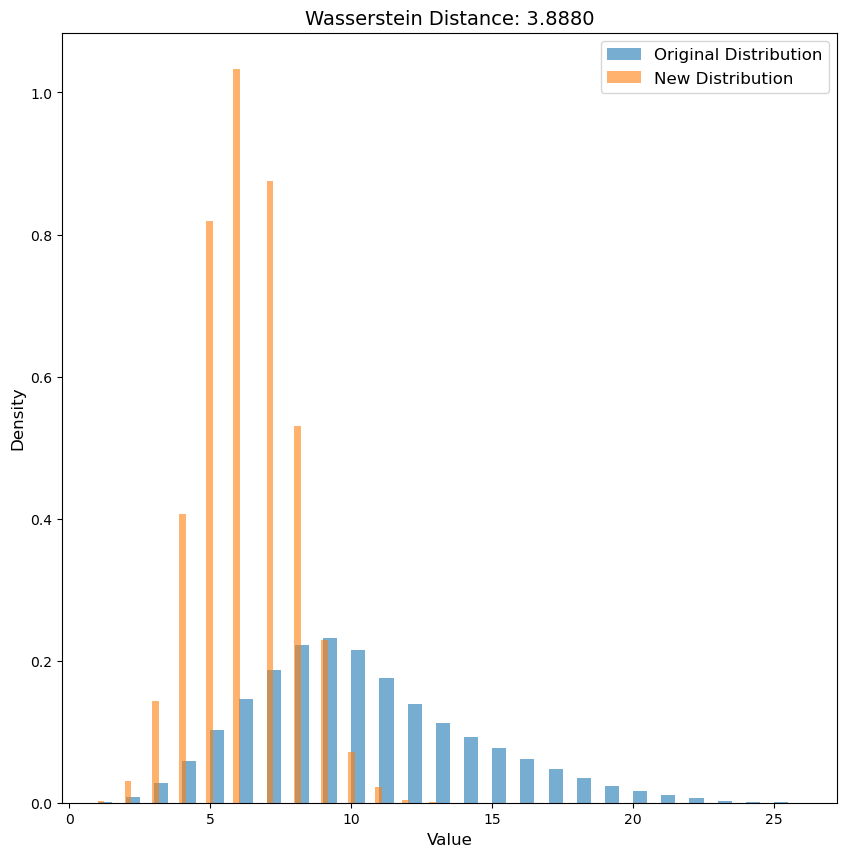

Gen Random with SP2: overlap count: 0


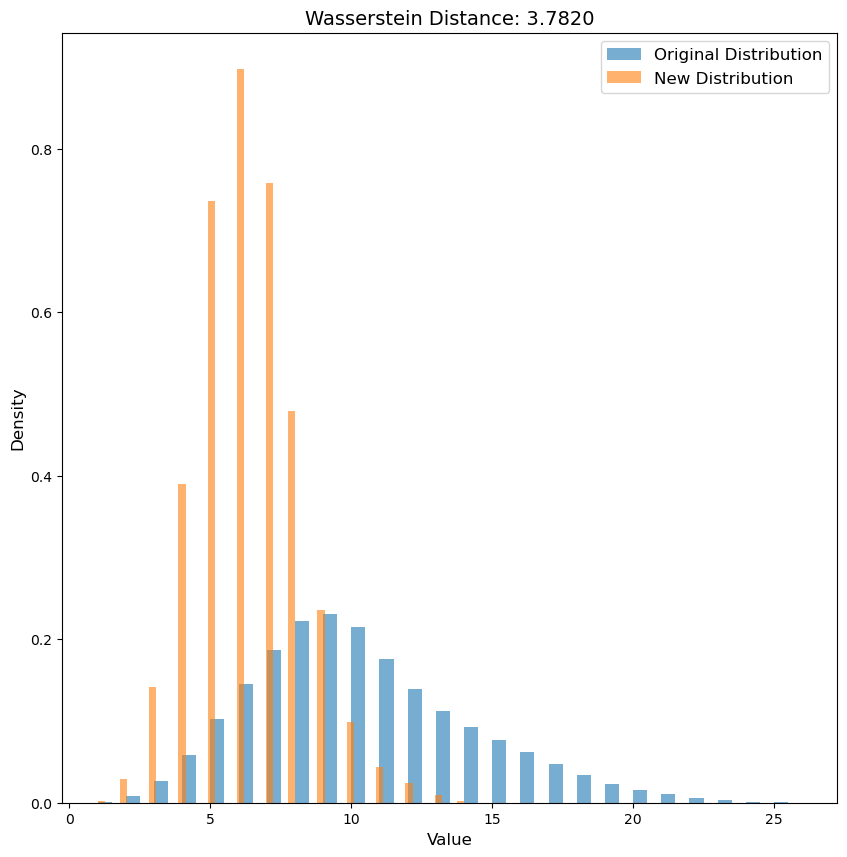

Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Trial 2 : gen rand graph with closest SP distri.
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0


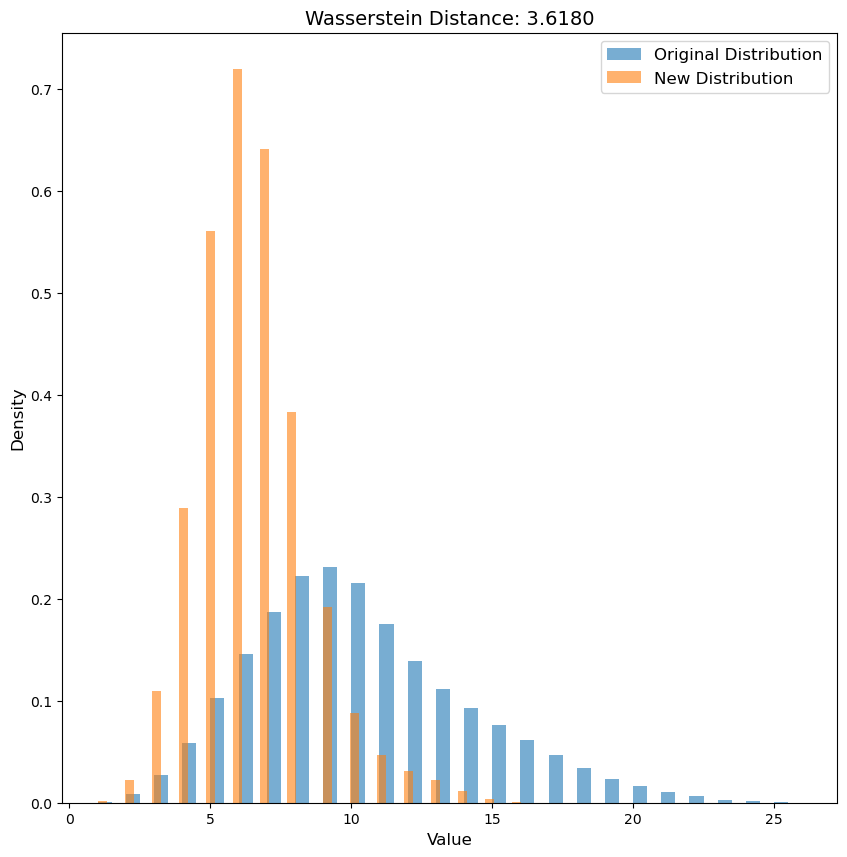

Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Trial 3 : gen rand graph with closest SP distri.
Gen Random with SP2: overlap count: 0


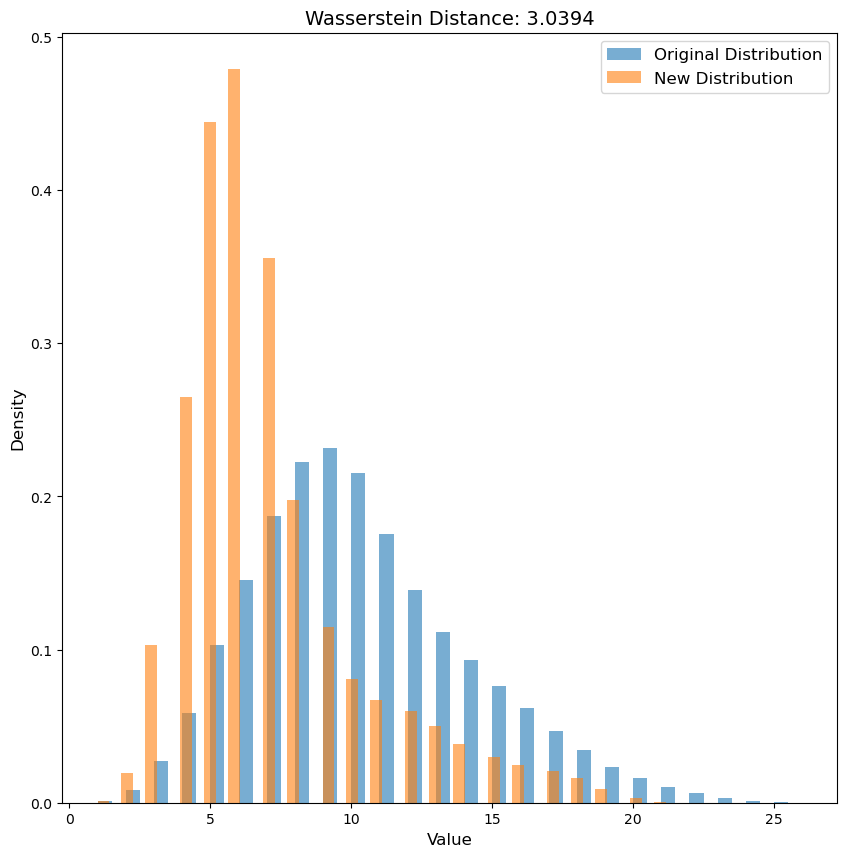

Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0


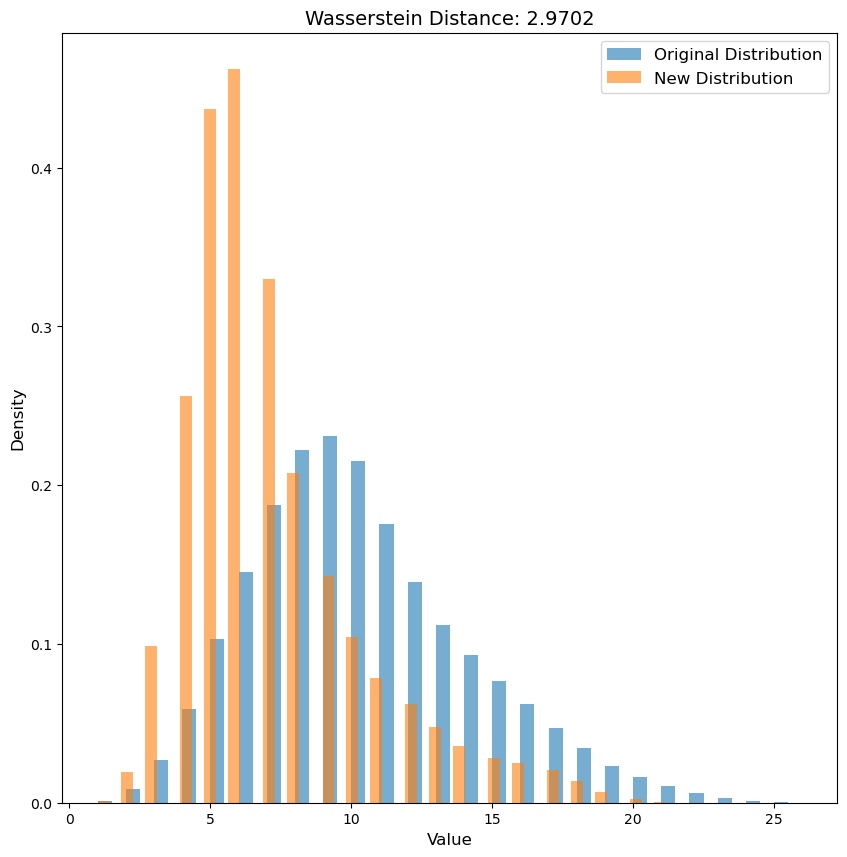

Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0


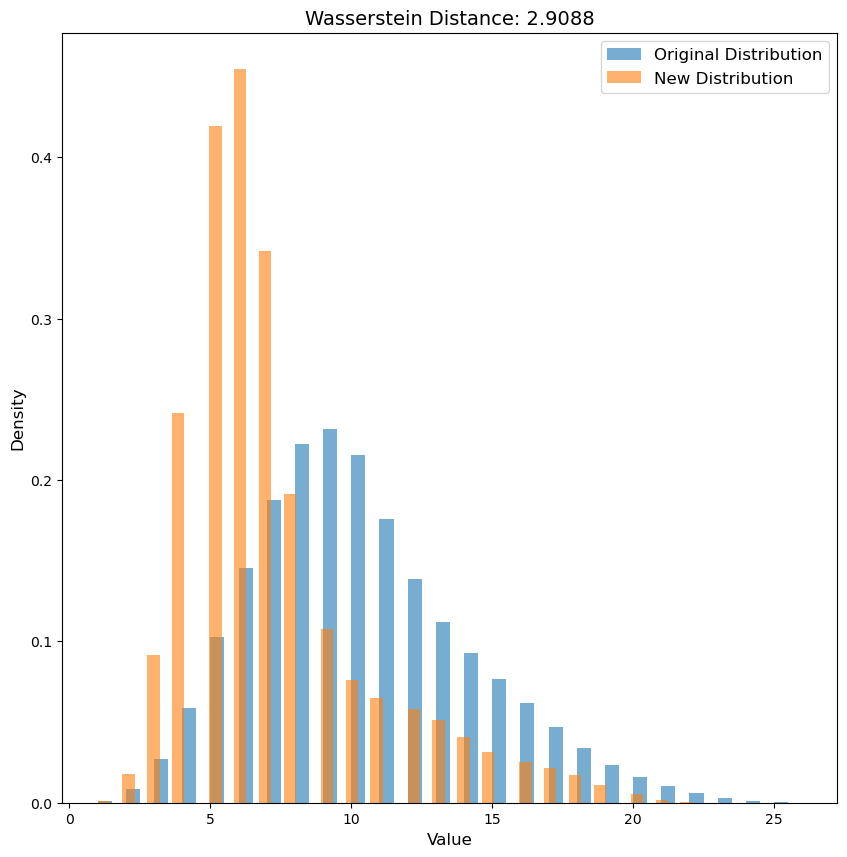

Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Trial 4 : gen rand graph with closest SP distri.
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Trial 5 : gen rand graph with closest SP distri.
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Gen Random with SP2: overlap count: 0
Trial 6 : gen rand graph with closest SP distri.
Gen Random with S

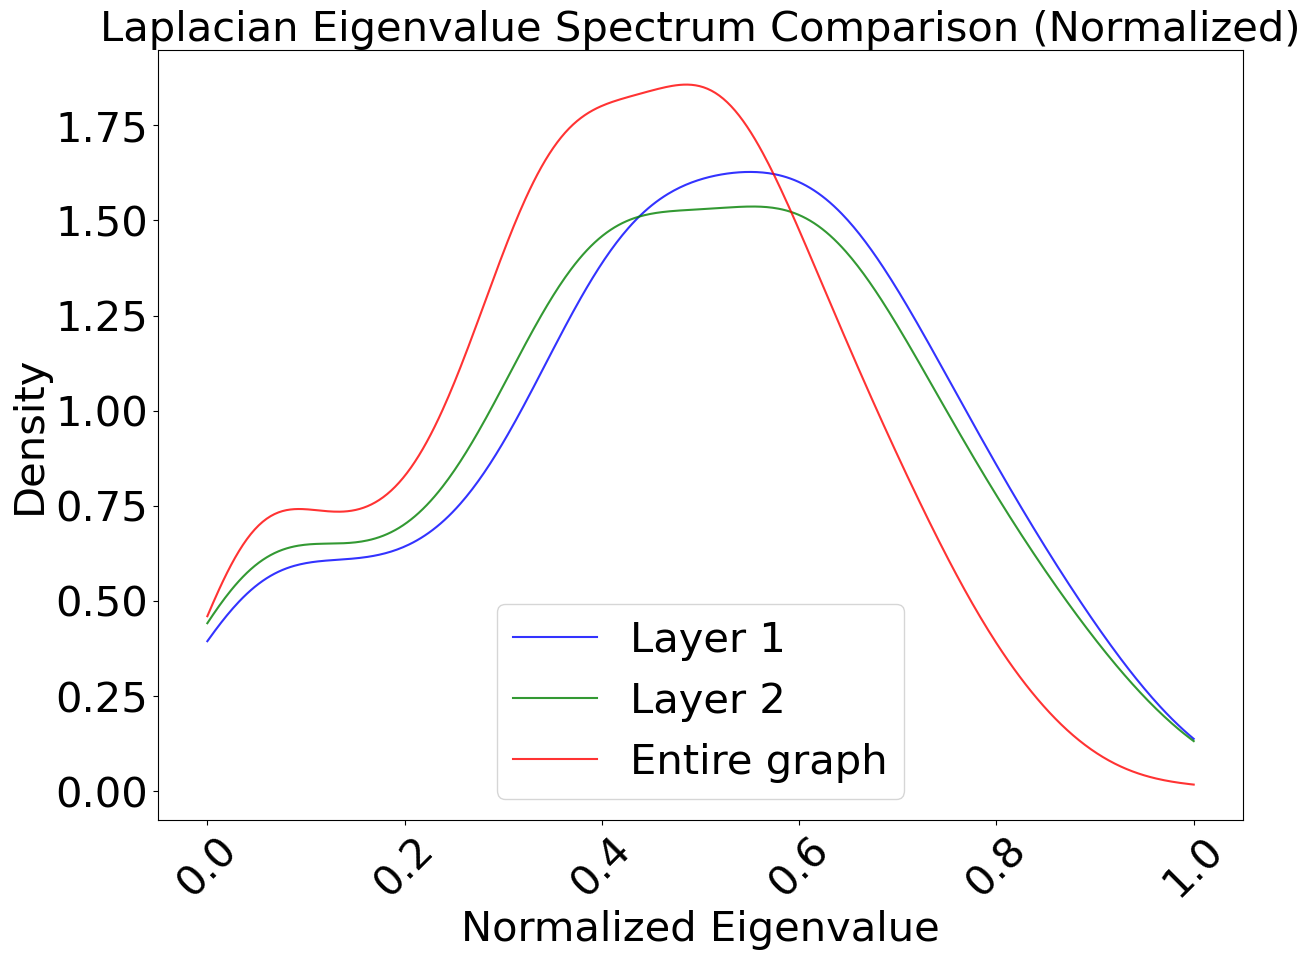

In [72]:
prot = Protein("data/fold_clock_bmal1_model_0.pdb", 7.)
g, layers = prot.getGraph()
l1, l2 = layers[0], layers[1]
# ccG = CompareContrast(g, layers, .9, 1000)
# ccG.plotMLModVCen()
# ccG.plotStrTiesBridges()
# ccG.plotSpectralProperties()
ri = RandomInterlayer(g, layers)
# rG1 = ri.getRand()
# ccRG1 = CompareContrast(rG1, layers, .9, 1000)
# ccRG1.plotMLModVCen()
# ccRG1.plotStrTiesBridges()
# ccRG1.plotSpectralProperties()
rG2, rG3 = ri.getRandTopo()
# ccRG2 = CompareContrast(rG2, layers, .9, 1000)
# ccRG2.plotMLModVCen()
# ccRG2.plotStrTiesBridges()
# ccRG2.plotSpectralProperties()
ccRG3 = CompareContrast(rG3, layers, .9, 1000)
# ccRG3.plotMLModVCen()
# ccRG3.plotStrTiesBridges()
ccRG3.plotSpectralProperties()


# ccG.plotModVCen()
# ccG.plotIntraModVCen()
# ccG.plotDependence()
# cc.calcTotalMod()
# ccG.plotModCompari()
# cc.plotMLModVCen()

# # g = rG3
# mc = MultiCens(g, layers, .9, 1000)
# m = mc.getMultiCens()
# m = np.array([m[i] for i in range(l1+l2)])

# e = nx.eigenvector_centrality(g, max_iter=1000, tol=1e-6)
# e = np.array([e[i] for i in range(l1+l2)])
# e = (e - e.min()) / (e.max() - e.min())

# layer1 = [x for x in range(layers[0])]
# layer2 = [x for x in range(layers[0], layers[0]+layers[1])]
# g1 = g.subgraph(layer1)
# g2 = g.subgraph(layer2)
# mlc = compute_node_metric(g, g1, g2)
# mlc = np.array([mlc[i] for i in range(l1+l2)])

# # compareRankings(layers, g, e, mlc)
# # compareRankings(layers, g, m, mlc)
# compareRankings(layers, g, e, m)




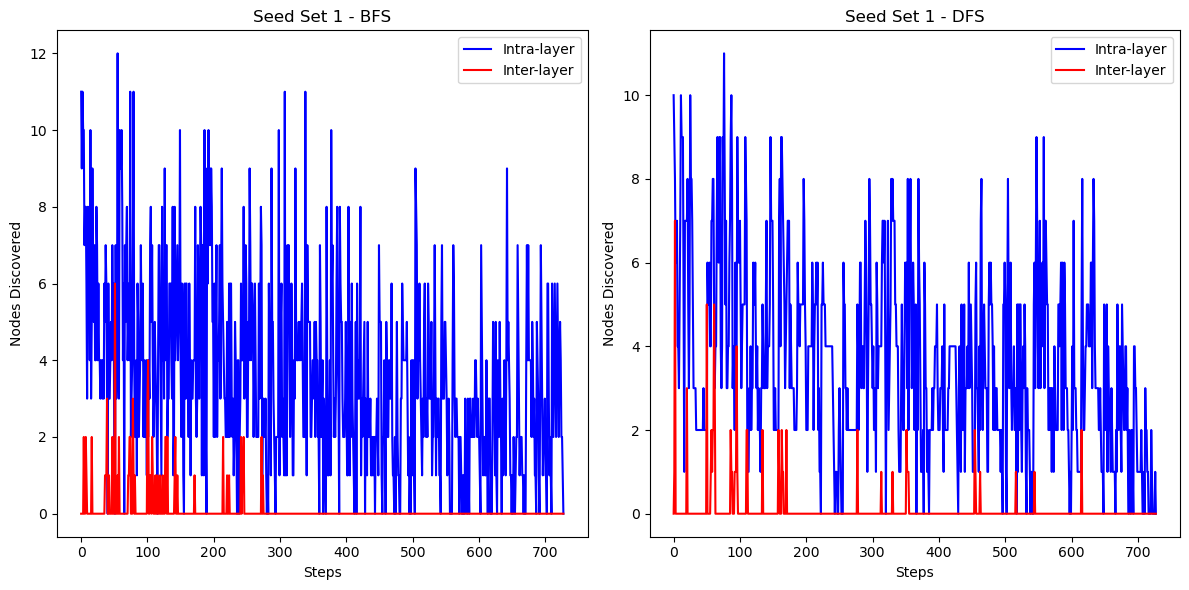

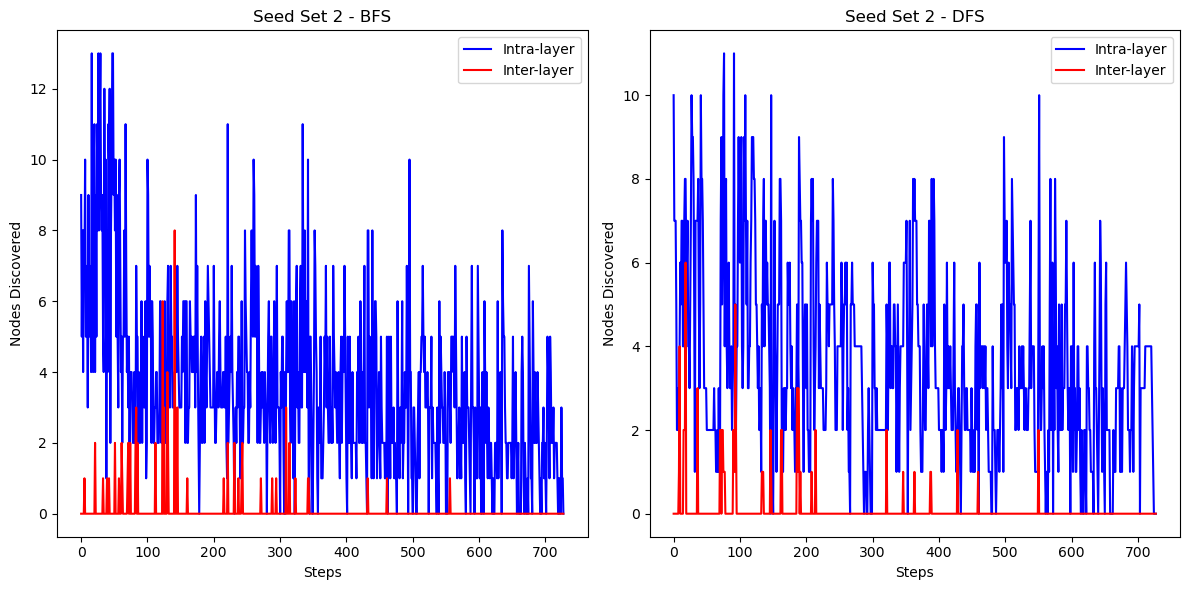

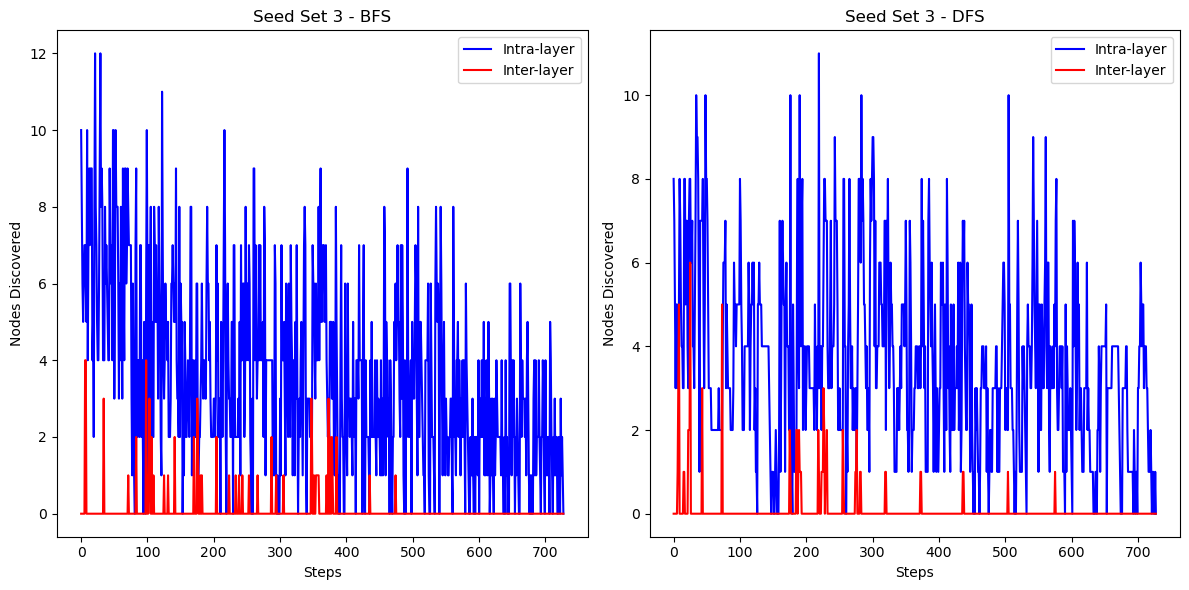

{}

In [578]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque



# Function to explore the graph using BFS and DFS
def explore_bfs(graph, start_nodes, node_layers):
    visited = set()
    queue = deque(start_nodes)
    intra_layer_count = []
    inter_layer_count = []
    
    while queue:
        current_node = queue.popleft()
        if current_node not in visited:
            visited.add(current_node)
            intra = 0
            inter = 0
            for neighbor in graph.neighbors(current_node):
                if neighbor not in visited:
                    queue.append(neighbor)
                    if neighbor in node_layers[current_node]:
                        intra += 1
                    else:
                        inter += 1
            intra_layer_count.append(intra)
            inter_layer_count.append(inter)
    
    return intra_layer_count, inter_layer_count, visited

def explore_dfs(graph, start_nodes, node_layers):
    visited = set()
    stack = list(start_nodes)
    intra_layer_count = []
    inter_layer_count = []
    
    while stack:
        current_node = stack.pop()
        if current_node not in visited:
            visited.add(current_node)
            intra = 0
            inter = 0
            for neighbor in graph.neighbors(current_node):
                if neighbor not in visited:
                    stack.append(neighbor)
                    if neighbor in node_layers[current_node]:
                        intra += 1
                    else:
                        inter += 1
            intra_layer_count.append(intra)
            inter_layer_count.append(inter)
    
    return intra_layer_count, inter_layer_count, visited

# Function to compare BFS and DFS for the seed sets
def compare_seed_sets(graph, seed_sets, node_layers):
    # For each seed set, perform BFS and DFS
    results = {}
    
    for i, seed_set in enumerate(seed_sets):
        bfs_intra, bfs_inter, bfs_visited = explore_bfs(graph, seed_set, node_layers)
        dfs_intra, dfs_inter, dfs_visited = explore_dfs(graph, seed_set, node_layers)
        
        # results[f"Seed Set {i+1} BFS"] = (bfs_intra, bfs_inter)
        # results[f"Seed Set {i+1} DFS"] = (dfs_intra, dfs_inter)
        
        # Plot BFS comparison for this seed set
        plt.figure(figsize=(12, 6))
        
        # BFS Intra/Inter comparison
        plt.subplot(1, 2, 1)
        plt.plot(range(len(bfs_intra)), bfs_intra, label="Intra-layer", color='b')
        plt.plot(range(len(bfs_inter)), bfs_inter, label="Inter-layer", color='r')
        plt.title(f'Seed Set {i+1} - BFS')
        plt.xlabel('Steps')
        plt.ylabel('Nodes Discovered')
        plt.legend()

        # DFS Intra/Inter comparison
        plt.subplot(1, 2, 2)
        plt.plot(range(len(dfs_intra)), dfs_intra, label="Intra-layer", color='b')
        plt.plot(range(len(dfs_inter)), dfs_inter, label="Inter-layer", color='r')
        plt.title(f'Seed Set {i+1} - DFS')
        plt.xlabel('Steps')
        plt.ylabel('Nodes Discovered')
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    return results

g = rG3
node_layers = {i: layer1 if i in layer1 else layer2 for i in g.nodes()}

# Example: Given 3 NumPy arrays for centrality values
centrality_array1 = e
centrality_array2 = m
centrality_array3 = mlc

# Stack the arrays for easier processing
centrality_arrays = [centrality_array1, centrality_array2, centrality_array3]

# Function to get the top 10 nodes by centrality values
def get_top_nodes(centrality_array, top_n=70):
    # Get indices of the top N centrality values
    top_indices = np.argsort(centrality_array)[-top_n:][::-1]  # Sort and reverse to get top N
    return top_indices

# Apply the function to get the top 10 nodes for each array
top_nodes_sets = [get_top_nodes(array) for array in centrality_arrays]
# print(top_nodes_sets)

# Print the top nodes for each case
# for i, top_nodes in enumerate(top_nodes_sets, 1):
#     print(f"Top 10 nodes for centrality set {i}: {top_nodes}")


# Compare the seed sets based on the centrality values
compare_seed_sets(g, top_nodes_sets, node_layers)

[222 223  93 224 220  92  94 184 186 221 219  95 225 185]
[267 264 179 527 435 263 223 438 266 528 526 458 437 180]
[258 298 340 721 460 210 388 121 625 389  25 667 537 110]


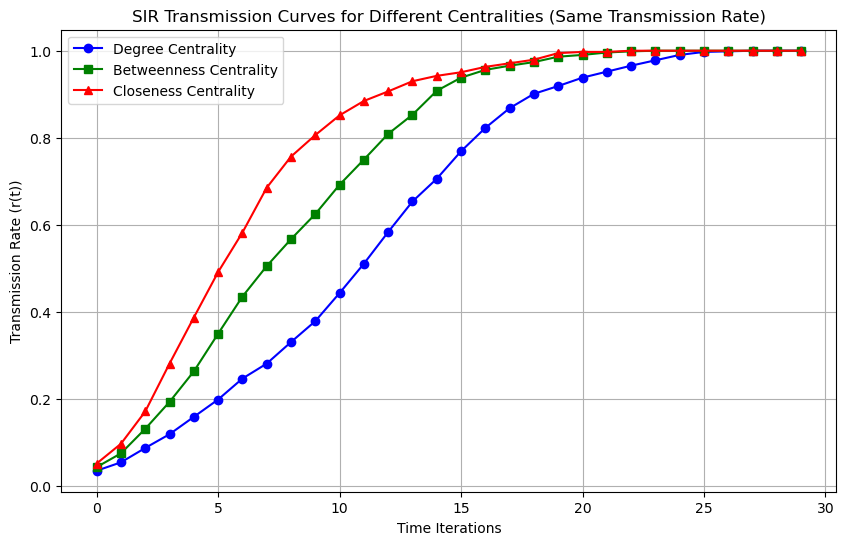

In [1188]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)


# np.random.seed(42)
# random.seed(42)

# Create a sample network (replace with your own graph)
# G = nx.erdos_renyi_graph(1000, 0.05)  # Example: 1000 nodes, 5% edge probability
G = g
# Compute centrality measures (Degree, Betweenness, Closeness)
# degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)

degree_centrality = e
betweenness_centrality = m
closeness_centrality = mlc
# print(normalized_scores)

mlc = np.load('mlc.npy')


# Function to simulate SIR dynamics for a given centrality measure
def simulate_SIR(centrality, beta=0.2, gamma=0.1, time_steps=30):
    # sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    # top_1_percent_nodes = [node for node, _ in sorted_nodes[:int(0.01 * len(G))]]
    
    top_1_percent_count = int(0.02 * len(centrality))  # Calculate 1% of the total nodes
    top_1_percent_nodes = np.argsort(centrality)[::-1][:top_1_percent_count]  # Get indices of top 1% nodes
    print(top_1_percent_nodes)

    susceptible = set(G.nodes)  # Initially all nodes are susceptible
    infected = set(top_1_percent_nodes)  # Top 1% nodes as initially infected
    recovered = set()  # Initially no recovered nodes
    infected_over_time = []  # To track the number of infected nodes over time

    # r = []
    # Simulation of SIR dynamics
    for t in range(time_steps):
        new_infected = set()
        for node in infected:
            neighbors = set(G.neighbors(node))  # Get neighbors of infected nodes
            for neighbor in neighbors:
                if neighbor in susceptible:
                    # Infection occurs with probability beta
                    # x = np.random.rand()
                    x = rng.rand()
                    # r.append(x)
                    if x < beta:
                        new_infected.add(neighbor)
        
        # Update SIR states
        infected = infected.union(new_infected)
        recovered = recovered.union(infected)
        susceptible = susceptible.difference(infected)
        
        # Track the number of infected nodes
        infected_over_time.append(len(infected) / len(G))
    # print(r)
    return infected_over_time

# Run the SIR model for each centrality (same transmission rate)
degree_transmission = simulate_SIR(degree_centrality)
betweenness_transmission = simulate_SIR(betweenness_centrality)
closeness_transmission = simulate_SIR(closeness_centrality)
# [322 694 648 479 478 713 703]

# Plotting the SIR transmission curves for each centrality
plt.figure(figsize=(10, 6))

# Plot each centrality's transmission curve
plt.plot(degree_transmission, label="Degree Centrality", color='b', marker='o')
plt.plot(betweenness_transmission, label="Betweenness Centrality", color='g', marker='s')
plt.plot(closeness_transmission, label="Closeness Centrality", color='r', marker='^')

# Mark the steady-state region (same steady state for all centralities since same transmission rate)
# plt.axhline(y=max(degree_transmission), color='b', linestyle='--', label='Steady State')

# Labels and title
plt.xlabel("Time Iterations")
plt.ylabel("Transmission Rate (r(t))")
plt.title("SIR Transmission Curves for Different Centralities (Same Transmission Rate)")
plt.legend()
plt.grid(True)
plt.show()

# [322 694 648 479 478 713 703]
# [322 648 694 479 478 425 644]

In [695]:
import torch
from torch_geometric.data import Data

# G1 (Layer 1)
edge_index_g1 = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)  # Example edges
x_g1 = torch.rand((3, 5))  # Example node features (3 nodes, 5 features each)
g1 = Data(x=x_g1, edge_index=edge_index_g1)

# G2 (Layer 2)
edge_index_g2 = torch.tensor([[0, 2], [2, 0]], dtype=torch.long)  # Example edges
x_g2 = torch.rand((3, 5))  # Node features
g2 = Data(x=x_g2, edge_index=edge_index_g2)

# G3 (Combined graph with interlayer edges)
edge_index_g3 = torch.cat(
    [edge_index_g1, edge_index_g2, torch.tensor([[0, 1], [2, 0]])], dim=1
)  # Adding interlayer edges
x_g3 = torch.rand((3, 5))  # Features for G3
g3 = Data(x=x_g3, edge_index=edge_index_g3)

from torch_geometric.nn import GATConv

class GATLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=1):
        super(GATLayer, self).__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, concat=False)
    
    def forward(self, x, edge_index):
        # Run GATConv in "return attention coefficients" mode
        out, alpha = self.gat(x, edge_index, return_attention_weights=True)
        return out, alpha

class CrossAttentionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CrossAttentionLayer, self).__init__()
        self.query = nn.Linear(in_channels, out_channels)
        self.key = nn.Linear(in_channels, out_channels)
        self.value = nn.Linear(in_channels, out_channels)
        self.fc = nn.Linear(out_channels, out_channels)
    
    def forward(self, h_g1, h_g2):
        # Cross-attention: G1 attending to G2
        query = self.query(h_g1)  # (N, out_channels)
        key = self.key(h_g2).transpose(0, 1)  # (out_channels, N)
        attention_weights = torch.softmax(torch.matmul(query, key), dim=-1)  # (N, N)
        
        # Weighted sum of values from G2
        h_cross = torch.matmul(attention_weights, self.value(h_g2))  # (N, out_channels)
        
        return self.fc(h_cross)

class MultiLayerAttentionModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=1, final_out_channels=None):
        super(MultiLayerAttentionModel, self).__init__()
        self.gat_g1 = GATLayer(in_channels, out_channels, heads)
        self.gat_g2 = GATLayer(in_channels, out_channels, heads)
        self.cross_attention = CrossAttentionLayer(out_channels, out_channels)
        
        self.fc = nn.Linear(out_channels * 2, final_out_channels) if final_out_channels else None
    
    def forward(self, x_g1, edge_index_g1, x_g2, edge_index_g2):
        # Learn node embeddings for G1 and G2
        h_g1, alpha_g1 = self.gat_g1(x_g1, edge_index_g1)
        h_g2, alpha_g2 = self.gat_g2(x_g2, edge_index_g2)
        
        # Cross-attention: G1 attends to G2 and vice versa
        h_cross_g1 = self.cross_attention(h_g1, h_g2)
        h_cross_g2 = self.cross_attention(h_g2, h_g1)
        
        # Combine representations (concatenate or weighted sum)
        h_combined = torch.cat([h_cross_g1, h_cross_g2], dim=1)
        
        # Final representation
        if self.fc:
            h_combined = self.fc(h_combined)
        
        return h_combined, h_g1, h_g2, alpha_g1, alpha_g2

import torch.nn.functional as F

# Define the model
in_channels = g1.num_node_features
out_channels = 8  # Hidden dimension
final_out_channels = g3.num_node_features  # Match G3's feature dimension
model = MultiLayerAttentionModel(in_channels, out_channels, heads=4, final_out_channels=final_out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    h_combined, h_g1, h_g2, _, _ = model(g1.x, g1.edge_index, g2.x, g2.edge_index)
    
    # Loss: Reconstruct G3's node features from G1 and G2
    loss = F.mse_loss(h_combined, g3.x) # Example: reconstruct G3 features
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

def get_attention_weights(model, g1, g2):
    model.eval()
    with torch.no_grad():
        _, _, _, alpha_g1, alpha_g2 = model(g1.x, g1.edge_index, g2.x, g2.edge_index)
    return alpha_g1, alpha_g2

attn_g1, attn_g2 = get_attention_weights(model, g1, g2)
print("Attention Weights for G1:", attn_g1)
print("Attention Weights for G2:", attn_g2)

Epoch 1, Loss: 0.5703768134117126
Epoch 2, Loss: 0.461595356464386
Epoch 3, Loss: 0.37397193908691406
Epoch 4, Loss: 0.30089834332466125
Epoch 5, Loss: 0.23808856308460236
Epoch 6, Loss: 0.18346776068210602
Epoch 7, Loss: 0.13697926700115204
Epoch 8, Loss: 0.10038088262081146
Epoch 9, Loss: 0.07680842280387878
Epoch 10, Loss: 0.06923741847276688
Epoch 11, Loss: 0.07614041864871979
Epoch 12, Loss: 0.08868516981601715
Epoch 13, Loss: 0.0969037339091301
Epoch 14, Loss: 0.09725046902894974
Epoch 15, Loss: 0.09192203730344772
Epoch 16, Loss: 0.0847996324300766
Epoch 17, Loss: 0.07884880900382996
Epoch 18, Loss: 0.07493706047534943
Epoch 19, Loss: 0.07238312810659409
Epoch 20, Loss: 0.07031597942113876
Epoch 21, Loss: 0.068464495241642
Epoch 22, Loss: 0.06709077954292297
Epoch 23, Loss: 0.06653174012899399
Epoch 24, Loss: 0.06680948287248611
Epoch 25, Loss: 0.06754031032323837
Epoch 26, Loss: 0.06814571470022202
Epoch 27, Loss: 0.06818165630102158
Epoch 28, Loss: 0.06755080819129944
Epoch 29

In [707]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.optim as optim

class GATLayer(nn.Module):
    # def __init__(self, in_channels, out_channels, heads=1):
    #     super(GATLayer, self).__init__()
    #     self.gat = GATConv(in_channels, out_channels, heads=heads, concat=False)
    
    # def forward(self, x, edge_index):
    #     out, alpha = self.gat(x, edge_index, return_attention_weights=True)
    #     return out, alpha
    def __init__(self, in_channels, out_channels, heads=1):
        super(GATLayer, self).__init__()
        # The in_channels is the input feature size (here set to 1 if no features)
        # out_channels is the number of output features (embedding size)
        self.gat = GATConv(in_channels, out_channels, heads=heads, concat=False)
    
    def forward(self, x, edge_index):
        # If no node features are provided, initialize as a tensor of ones
        if x is None:
            x = torch.ones((edge_index.max().item() + 1, 1), device=edge_index.device)  # (num_nodes, 1)
        
        # Apply GATConv: learn node embeddings based on the graph structure
        out, alpha = self.gat(x, edge_index, return_attention_weights=True)
        return out, alpha

class CrossAttentionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CrossAttentionLayer, self).__init__()
        self.query = nn.Linear(in_channels, out_channels)
        self.key = nn.Linear(in_channels, out_channels)
        self.value = nn.Linear(in_channels, out_channels)
        self.fc = nn.Linear(out_channels, out_channels)
    
    # def forward(self, h_g1, h_g2):
    #     query = self.query(h_g1)  # (N, out_channels)
    #     key = self.key(h_g2).transpose(0, 1)  # (out_channels, N)
    #     attention_weights = torch.softmax(torch.matmul(query, key), dim=-1)  # (N, N)
    #     h_cross = torch.matmul(attention_weights, self.value(h_g2))  # (N, out_channels)
    #     return self.fc(h_cross)

    def forward(self, h_g1, h_g2):
        # Cross-attention: G1 attending to G2
        query = self.query(h_g1)  # (N, out_channels) for G1
        key = self.key(h_g2)      # (N, out_channels) for G2
        value = self.value(h_g2)  # (N, out_channels) for G2
        
        # Compute the attention scores (similarity between G1 and G2)
        attention_scores = torch.matmul(query, key.t())  # (N, N) - Dot product of query and key
        
        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=-1)  # (N, N)
        
        # Weighted sum of values from G2 based on attention weights
        h_cross = torch.matmul(attention_weights, value)  # (N, out_channels)
        
        # Optionally pass through a final fully connected layer
        return self.fc(h_cross)

class MultiLayerAttentionModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=1, final_out_channels=None):
        super(MultiLayerAttentionModel, self).__init__()
        self.gat_g1 = GATLayer(in_channels, out_channels, heads)
        self.gat_g2 = GATLayer(in_channels, out_channels, heads)
        self.cross_attention = CrossAttentionLayer(out_channels, out_channels)
        
        self.fc = nn.Linear(out_channels * 2, final_out_channels) if final_out_channels else None
    
    def forward(self, x_g1, edge_index_g1, x_g2, edge_index_g2):
        # Learn node embeddings for G1 and G2
        h_g1, alpha_g1 = self.gat_g1(x_g1, edge_index_g1)
        h_g2, alpha_g2 = self.gat_g2(x_g2, edge_index_g2)
        
        # Cross-attention: G1 attends to G2 and vice versa
        h_cross_g1 = self.cross_attention(h_g1, h_g2)
        h_cross_g2 = self.cross_attention(h_g2, h_g1)
        
        # Combine representations (concatenate or weighted sum)
        h_combined = torch.cat([h_cross_g1, h_cross_g2], dim=1)
        
        # Final representation
        if self.fc:
            h_combined = self.fc(h_combined)
        
        return h_combined, h_g1, h_g2, alpha_g1, alpha_g2

    # def reconstruct_adj_matrix(self, embeddings, threshold=0.5):
    #     # Compute the similarity (e.g., dot product) between embeddings
    #     adj_matrix_pred = torch.matmul(embeddings, embeddings.t())  # Similarity matrix (dot product)
        
    #     # Apply sigmoid to get probabilities
    #     adj_matrix_pred = torch.sigmoid(adj_matrix_pred)
        
    #     # Apply threshold to create binary matrix (1 for predicted edge, 0 otherwise)
    #     adj_matrix_pred = (adj_matrix_pred > threshold).float()
        
    #     return adj_matrix_pred

    # def structural_loss(self, h_combined, edge_index_g3):
    #     """
    #     Compute structural loss by predicting the edges in the combined graph G3.
    #     """
    #     # Concatenate embeddings from G1 and G2
    #     # combined_embeddings = torch.cat([h_g1, h_g2], dim=1)  # Combine embeddings
    #     combined_embeddings = h_combined
        
    #     # Predict edge weights between all pairs of nodes
    #     edge_weights = torch.matmul(combined_embeddings, combined_embeddings.T)
        
    #     # Create a binary mask for edges present in G3
    #     edge_mask = torch.zeros_like(edge_weights)
    #     for i, j in zip(edge_index_g3[0], edge_index_g3[1]):
    #         edge_mask[i, j] = 1
        
    #     # Calculate loss
    #     return F.binary_cross_entropy_with_logits(edge_weights, edge_mask)

    def structural_loss(self, adj_matrix_pred, adj_matrix_true):
        # Compute binary cross-entropy loss between predicted and true adjacency matrices
        return F.binary_cross_entropy(adj_matrix_pred, adj_matrix_true)
    
    def get_adj_matrix_from_edge_index(self, edge_index, num_nodes):
        adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
        row, col = edge_index
        adj_matrix[row, col] = 1  # Set edges to 1
        adj_matrix[col, row] = 1  # Since the graph is undirected
        return adj_matrix
    
    def reconstruct_adj_matrix(self, embeddings, threshold=0.5):
        # Compute the similarity (e.g., dot product) between embeddings
        adj_matrix_pred = torch.matmul(embeddings, embeddings.t())  # Similarity matrix (dot product)
        
        # Apply sigmoid to get probabilities
        adj_matrix_pred = torch.sigmoid(adj_matrix_pred)
        
        # Apply threshold to create binary matrix (1 for predicted edge, 0 otherwise)
        adj_matrix_pred = (adj_matrix_pred > threshold).float()
        
        return adj_matrix_pred

# Create graphs
edge_index_g1 = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)  # Example edges for G1
x_g1 = torch.rand((3, 5))  # Node features for G1
g1 = Data(x=x_g1, edge_index=edge_index_g1)
g1.x.requires_grad_()  # Make sure the input features for G1 are tracked by autograd

edge_index_g2 = torch.tensor([[0, 2], [2, 0]], dtype=torch.long)  # Example edges for G2
x_g2 = torch.rand((3, 5))  # Node features for G2
g2 = Data(x=x_g2, edge_index=edge_index_g2)
g1.x.requires_grad_()  # Make sure the input features for G1 are tracked by autograd

edge_index_g3 = torch.cat(
    [edge_index_g1, edge_index_g2, torch.tensor([[0, 1], [2, 0]])], dim=1
)  # Adding interlayer edges
x_g3 = torch.rand((3, 5))  # Features for G3
g3 = Data(x=x_g3, edge_index=edge_index_g3)

# Initialize and train the model
model = MultiLayerAttentionModel(in_channels=5, out_channels=8)
# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"Parameter {name} doesn't require gradients.")
for param in model.parameters():
    param.requires_grad = True

# Training loop
for epoch in range(100):  # Training for 100 epochs (adjust as needed)
    model.train()
    # optimizer.zero_grad()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Forward pass
    h_combined, h_g1, h_g2, alpha_g1, alpha_g2 = model(g1.x, g1.edge_index, g2.x, g2.edge_index)
    adj_matrix_pred = model.reconstruct_adj_matrix(h_combined)
    adj_matrix_true = model.get_adj_matrix_from_edge_index(g3.edge_index, num_nodes=g3.num_nodes)

    
    # Compute structural loss (edge prediction)
    # loss = model.structural_loss(h_combined, g3.edge_index)
    loss = model.structural_loss(adj_matrix_pred, adj_matrix_true)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [717]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

class GATLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=1):
        super(GATLayer, self).__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, concat=False)
    
    def forward(self, x, edge_index):
        # Forward pass through GAT layer
        out, alpha = self.gat(x, edge_index, return_attention_weights=True)
        return out, alpha

class CrossAttentionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CrossAttentionLayer, self).__init__()
        self.query = nn.Linear(in_channels, out_channels)
        self.key = nn.Linear(in_channels, out_channels)
        self.value = nn.Linear(in_channels, out_channels)
        self.fc = nn.Linear(out_channels, out_channels)
    
    def forward(self, h_g1, h_g2):
        # Cross-attention: G1 attending to G2
        query = self.query(h_g1)  # (N, out_channels)
        key = self.key(h_g2).transpose(0, 1)  # (out_channels, N)
        attention_weights = torch.softmax(torch.matmul(query, key), dim=-1)  # (N, N)
        
        # Weighted sum of values from G2
        h_cross = torch.matmul(attention_weights, self.value(h_g2))  # (N, out_channels)
        
        return h_cross, attention_weights

class MultiLayerAttentionModel(nn.Module):
    def __init__(self, in_channels, out_channels, heads=1, final_out_channels=None):
        super(MultiLayerAttentionModel, self).__init__()
        self.gat_g1 = GATLayer(in_channels, out_channels, heads)
        self.gat_g2 = GATLayer(in_channels, out_channels, heads)
        self.cross_attention = CrossAttentionLayer(out_channels, out_channels)
        
        self.fc = nn.Linear(out_channels * 2, final_out_channels) if final_out_channels else None
    
    def forward(self, edge_index_g1, edge_index_g2):
        # Initialize node features as constant or random (no semantic features)
        num_nodes_g1 = edge_index_g1.max() + 1
        num_nodes_g2 = edge_index_g2.max() + 1
        x_g1 = torch.ones((num_nodes_g1, 1))  # Constant feature (ones) for G1
        x_g2 = torch.ones((num_nodes_g2, 1))  # Constant feature (ones) for G2
        
        # Learn node embeddings for G1 and G2 (purely based on structure)
        h_g1, alpha_g1 = self.gat_g1(x_g1, edge_index_g1)
        h_g2, alpha_g2 = self.gat_g2(x_g2, edge_index_g2)
        
        # Cross-attention: Use the learned embeddings from GAT
        h_cross_g1, alpha_cross_g1 = self.cross_attention(h_g1, h_g2)  # G1 attends to G2
        h_cross_g2, alpha_cross_g2 = self.cross_attention(h_g2, h_g1)  # G2 attends to G1
        
        # Now, we want to combine these embeddings while keeping each node's embedding distinct.
        # The final embedding length will be the sum of the individual graph embeddings
        h_combined = torch.cat([h_cross_g1, h_cross_g2], dim=0)  # Concatenate embeddings from both graphs
        
        # Final representation (Optional)
        if self.fc:
            h_combined = self.fc(h_combined)
        
        return h_combined, h_g1, h_g2, alpha_g1, alpha_g2, alpha_cross_g1, alpha_cross_g2

# Example usage:

# G1 (Layer 1)
edge_index_g1 = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long)  # Example edges for G1
g1 = Data(edge_index=edge_index_g1)

# G2 (Layer 2)
edge_index_g2 = torch.tensor([[0, 2], [2, 0]], dtype=torch.long)  # Example edges for G2
g2 = Data(edge_index=edge_index_g2)

# Define the model and call it
model = MultiLayerAttentionModel(in_channels=1, out_channels=8)

# Assume edge_index_g1 and edge_index_g2 are the edge lists for G1 and G2
h_combined, h_g1, h_g2, alpha_g1, alpha_g2, alpha_cross_g1, alpha_cross_g2 = model(edge_index_g1, edge_index_g2)

# alpha_cross_g1 and alpha_cross_g2 are the attention weights between G1 and G2
print("Combined Embeddings:", h_combined[:,0])  # Combined embeddings for both graphs
print("Attention Weights for G1 -> G2:", alpha_cross_g1)
print("Attention Weights for G2 -> G1:", alpha_cross_g2)

Combined Embeddings: tensor([0.0593, 0.0593, 0.0593, 0.1040, 0.1040, 0.1040],
       grad_fn=<SelectBackward0>)
Attention Weights for G1 -> G2: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], grad_fn=<SoftmaxBackward0>)
Attention Weights for G2 -> G1: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], grad_fn=<SoftmaxBackward0>)


16


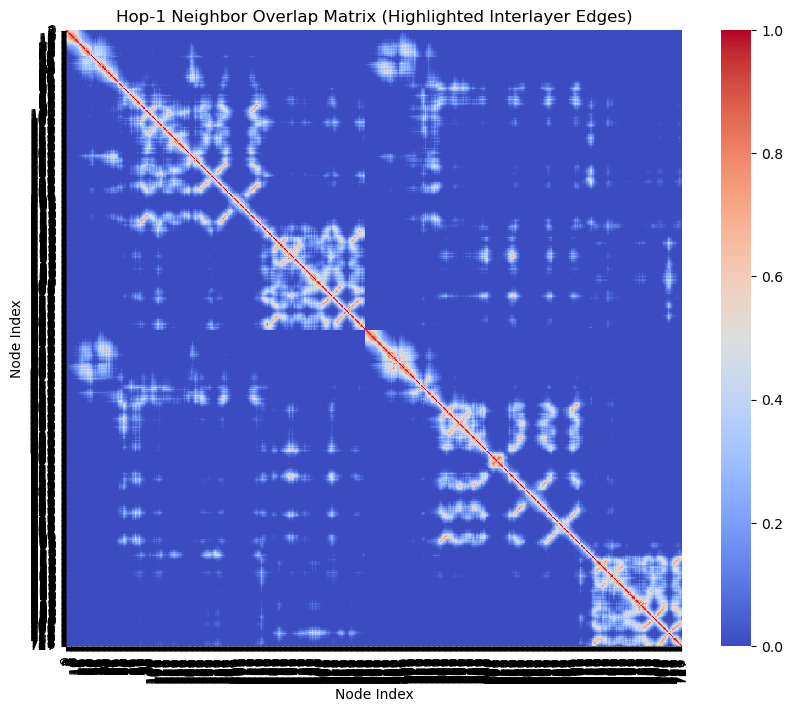

In [859]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Create a sample graph with interlayer edges (multi-layer graph example)
# We'll create a simple two-layer graph (with interlayer edges) for demonstration.
G = nx.Graph()
# Add nodes for two layers (layer1 and layer2)
layer1 = range(5)
layer2 = range(5, 10)
G.add_nodes_from(layer1, layer='layer1')
G.add_nodes_from(layer2, layer='layer2')

# Add intra-layer edges (edges within layer1 and layer2)
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4)])
G.add_edges_from([(5, 6), (6, 7), (7, 8), (8, 9)])

# Add interlayer edges (edges between layer1 and layer2)
G.add_edges_from([(0, 5), (1, 6), (2, 7), (3, 8), (4, 9)])


layer1 = [i for i in range(layers[0])]
layer2 = [i for i in range(layers[0],layers[0]+layers[1])]
l1g = g.subgraph(layer1)
l2g = g.subgraph(layer2)
# Extract all edges from the main graph
all_edges = set(g.edges())

G = g

# Extract edges from layer 1 and layer 2 subgraphs
l1_nodes = set(l1g.nodes())
l2_nodes = set(l2g.nodes())

interlayer_edges = [(u, v) for u, v in g.edges() if (u in l1_nodes and v in l2_nodes) or (u in l2_nodes and v in l1_nodes)]


# Function to calculate Jaccard similarity (hop-1 overlap)
def jaccard_similarity_neighbors(G, node1, node2):
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    intersection = len(neighbors1.intersection(neighbors2))
    union = len(neighbors1.union(neighbors2))
    return intersection / union if union > 0 else 0

def getDegNormL3(g, neighI, neighJ):
    pij = float(0)
    for u in neighI:
        uDegree = g.degree(u)
        for v in neighJ:
            if g.has_edge(u, v):
                vDegree = g.degree(v)
                pij += 1.0/(uDegree*vDegree)**(1/2)
    # print(degNormL3)
    return(pij)

def get_2hop_neighbors(graph, node):
    one_hop_neighbors = set(nx.neighbors(graph, node))
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors.update(nx.neighbors(graph, neighbor))
    two_hop_neighbors.discard(node)  # Remove the node itself if present
    return two_hop_neighbors

def get_khop_neighbors(graph, node, k):
    # Use BFS to find all neighbors up to k hops
    visited = {node}
    current_level = {node}
    for _ in range(k):
        next_level = set()
        for n in current_level:
            next_level.update(graph.neighbors(n))
        next_level -= visited
        visited.update(next_level)
        current_level = next_level
    return visited - {node}  # Exclude the original node

def estimate_khop_overlap(graph, node1, node2, k, num_samples=100):
    """
    Estimate k-hop neighbor overlap using Monte Carlo sampling.
    """
    def sample_khop_neighbors(graph, node, k, num_samples):
        visited = {node}
        current_level = {node}
        for _ in range(k):
            next_level = set()
            for n in current_level:
                next_level.update(graph.neighbors(n))
            next_level -= visited
            visited.update(next_level)
            # Convert set to list for random.sample
            current_level = random.sample(list(next_level), min(num_samples, len(next_level)))
        return visited

    n1_neighbors = sample_khop_neighbors(graph, node1, k, num_samples)
    n2_neighbors = sample_khop_neighbors(graph, node2, k, num_samples)
    intersection = len(n1_neighbors & n2_neighbors)
    union = len(n1_neighbors | n2_neighbors)
    return intersection / union if union > 0 else 0.0


def estimate_effective_diameter(graph, percentile=0.9):
    """
    Estimate effective diameter of the graph.
    """
    all_lengths = []
    for source in graph.nodes():
        lengths = nx.single_source_shortest_path_length(graph, source)
        all_lengths.extend(lengths.values())
    max_length = max(all_lengths)
    hist = [0] * (max_length + 1)
    for length in all_lengths:
        hist[length] += 1
    cumulative = [sum(hist[:i+1]) for i in range(len(hist))]
    total_pairs = cumulative[-1]
    effective_diameter = next(i for i, count in enumerate(cumulative) if count >= total_pairs * percentile)
    return effective_diameter

# Create the overlap matrix
nodes = list(G.nodes())
nodes.sort()
# nodes = nodes[:200]
overlap_matrix = np.zeros((len(nodes), len(nodes)))

k = estimate_effective_diameter(G)
print(k)
k=6
# Compute hop-1 overlap (Jaccard similarity) for each pair of nodes
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        # overlap_matrix[i][j] = jaccard_similarity_neighbors(G, node_i, node_j)
        
        # neighbors1 = set(G.neighbors(node_i))
        # neighbors2 = set(G.neighbors(node_j))
        # overlap_matrix[i][j] = getDegNormL3(G, neighbors1, neighbors2)

        # n2_i = get_2hop_neighbors(G, node_i)
        # n2_j = get_2hop_neighbors(G, node_j)
        # intersection = len(n2_i & n2_j)
        # union = len(n2_i | n2_j)
        # overlap_matrix[i, j] = intersection / union if union > 0 else 0.0

        n3_i = get_khop_neighbors(g, nodes[i], 3)
        n3_j = get_khop_neighbors(g, nodes[j], 3)
        intersection = len(n3_i & n3_j)
        union = len(n3_i | n3_j)
        overlap_matrix[i, j] = intersection / union if union > 0 else 0.0
        
        # overlap_matrix[i][j] = estimate_khop_overlap(G, node_i, node_j, k)

# Identify interlayer edges (between layer1 and layer2)
# interlayer_edges = set((min(u, v), max(u, v)) for u, v in G.edges() if G.nodes[u]['layer'] != G.nodes[v]['layer'])

# min_val = np.min(overlap_matrix)
# max_val = np.max(overlap_matrix)

# # Create a mask for interlayer edges in the matrix
# highlight_mask = np.zeros_like(overlap_matrix, dtype=bool)
# for u, v in interlayer_edges:
#     i, j = nodes.index(u), nodes.index(v)
#     highlight_mask[i][j] = True
#     highlight_mask[j][i] = True  # Symmetric position

# Plot the matrix with highlighting interlayer edges
plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(
    overlap_matrix,
    # annot=True,  # Annotate each cell with its value
    cmap="coolwarm",  # Color map
    cbar=True,  # Show the color bar
    xticklabels=nodes, 
    yticklabels=nodes,
    linewidths=0,  # Add grid lines between cells
    linecolor="black",  # Color of grid lines
    square=True,  # Make cells square
    vmin=np.min(overlap_matrix),  # Adjust color scale
    vmax=np.max(overlap_matrix)
)

# # Highlight interlayer edges
# for i in range(len(nodes)):
#     for j in range(len(nodes)):
#         if highlight_mask[i, j]:  # If the cell is an interlayer edge
#             plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='yellow', lw=2))

plt.title("Hop-1 Neighbor Overlap Matrix (Highlighted Interlayer Edges)")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

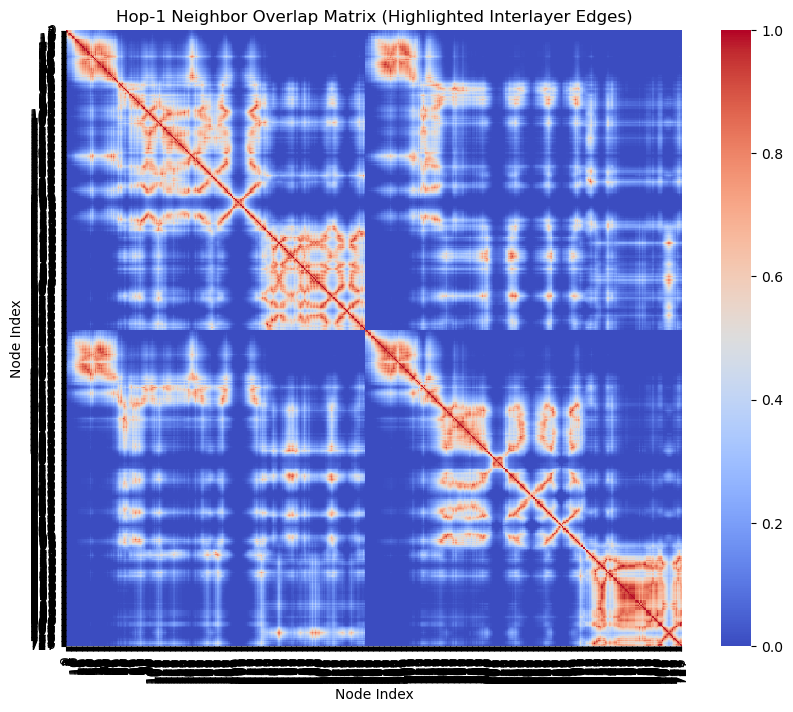

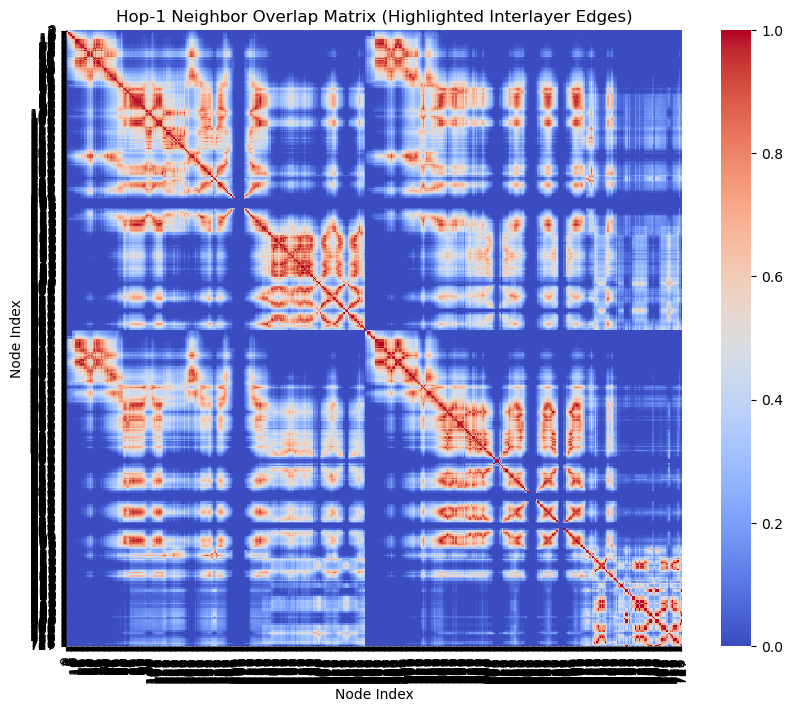

In [948]:
layer1 = [i for i in range(layers[0])]
layer2 = [i for i in range(layers[0],layers[0]+layers[1])]
l1g = g.subgraph(layer1)
l2g = g.subgraph(layer2)
# Extract all edges from the main graph
all_edges = set(g.edges())

G = g
# Extract edges from layer 1 and layer 2 subgraphs
l1_nodes = set(l1g.nodes())
l2_nodes = set(l2g.nodes())
nodes = list(G.nodes())
nodes.sort()

interlayer_edges = [(u, v) for u, v in g.edges() if (u in l1_nodes and v in l2_nodes) or (u in l2_nodes and v in l1_nodes)]
interlayer_nodes = set()
for u,v in interlayer_edges:
    interlayer_nodes.add(u)
    interlayer_nodes.add(v)
intralayer_nodes = set(nodes)-set(interlayer_nodes)

def get_khop_neighbors(graph, node, k):
    visited = {node}
    current_level = {node}
    intra_layer_neighbors = set()
    inter_layer_neighbors = set()
    for _ in range(k):
        next_level = set()
        for n in current_level:
            for neighbor in graph.neighbors(n):
                if neighbor not in visited:
                    next_level.add(neighbor)
                    # Classify neighbor based on layer
                    if neighbor in intralayer_nodes:
                        intra_layer_neighbors.add(neighbor)
                    else:
                        inter_layer_neighbors.add(neighbor)
        visited.update(next_level)
        current_level = next_level

    return intra_layer_neighbors, inter_layer_neighbors

def get_khop_neighbors2(graph, node, k):
    # Use BFS to find all neighbors up to k hops
    visited = {node}
    current_level = {node}
    for _ in range(k):
        next_level = set()
        for n in current_level:
            next_level.update(graph.neighbors(n))
        next_level -= visited
        visited.update(next_level)
        current_level = next_level
    return visited - {node}  # Exclude the original node

overlap_matrix = np.zeros((len(nodes), len(nodes)))
# overlap_matrix2 = np.zeros((len(nodes), len(nodes)))
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        n3_i_intra, n3_i_inter  = get_khop_neighbors(g, nodes[i], 6)
        n3_j_intra, n3_j_inter  = get_khop_neighbors(g, nodes[j], 6)
        intersection = len(n3_i_intra & n3_j_intra)
        union = len(n3_i_intra | n3_j_intra)
        overlap_matrix[i, j] = intersection / union if union > 0 else 0.0
        intersection = len(n3_i_inter & n3_j_inter)
        union = len(n3_i_inter | n3_j_inter)
        overlap_matrix2[i, j] = intersection / union if union > 0 else 0.0


        # n3_i = get_khop_neighbors2(g, nodes[i], 6)
        # n3_j = get_khop_neighbors2(g, nodes[j], 6)
        # intersection = len(n3_i & n3_j)
        # union = len(n3_i | n3_j)
        # overlap_matrix[i, j] = intersection / union if union > 0 else 0.0

plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(
    overlap_matrix,
    # annot=True,  # Annotate each cell with its value
    cmap="coolwarm",  # Color map
    cbar=True,  # Show the color bar
    xticklabels=nodes, 
    yticklabels=nodes,
    linewidths=0,  # Add grid lines between cells
    linecolor="black",  # Color of grid lines
    square=True,  # Make cells square
    vmin=np.min(overlap_matrix),  # Adjust color scale
    vmax=np.max(overlap_matrix)
)
plt.title("Hop-1 Neighbor Overlap Matrix (Highlighted Interlayer Edges)")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(
    overlap_matrix2,
    # annot=True,  # Annotate each cell with its value
    cmap="coolwarm",  # Color map
    cbar=True,  # Show the color bar
    xticklabels=nodes, 
    yticklabels=nodes,
    linewidths=0,  # Add grid lines between cells
    linecolor="black",  # Color of grid lines
    square=True,  # Make cells square
    vmin=np.min(overlap_matrix),  # Adjust color scale
    vmax=np.max(overlap_matrix)
)
plt.title("Hop-1 Neighbor Overlap Matrix (Highlighted Interlayer Edges)")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

# np.save("intra12_6", overlap_matrix)
# np.save("overall31_6", overlap_matrix)
np.save("intra21_6", overlap_matrix)
np.save("inter22_6", overlap_matrix2)

k: 2
[258 298 340 721 460 210 388 121 625 389  25 667 537 110]


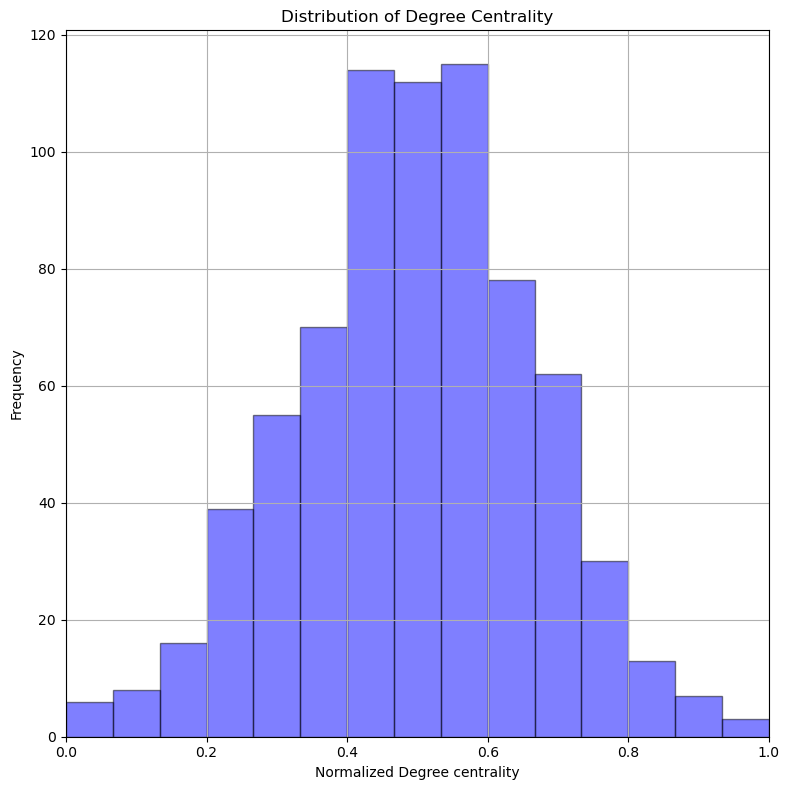

In [1180]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm
from scipy.linalg import eig
rng = np.random.RandomState(42)

layer1 = [i for i in range(layers[0])]
layer2 = [i for i in range(layers[0],layers[0]+layers[1])]
l1g = g.subgraph(layer1)
l2g = g.subgraph(layer2)
# # Extract all edges from the main graph
# all_edges = set(g.edges())

# G = l1g
# # Extract edges from layer 1 and layer 2 subgraphs
# l1_nodes = set(l1g.nodes())
# l2_nodes = set(l2g.nodes())
# nodes = list(G.nodes())
# nodes.sort()

# interlayer_edges = [(u, v) for u, v in g.edges() if (u in l1_nodes and v in l2_nodes) or (u in l2_nodes and v in l1_nodes)]
# intralayer_edges = [(u, v) for u, v in g.edges() if (u in l1_nodes and v in l1_nodes) or (u in l2_nodes and v in l2_nodes)]
# ginter = g.edge_subgraph(interlayer_edges)
# print(len(list(ginter.edges())))
# gintra = g.edge_subgraph(intralayer_edges)
# print(len(list(gintra.edges())))

# def compute_khop_overlap_sparse(adj_matrix, k):
#     adj_matrix = csr_matrix(adj_matrix)
#     khop_matrix = adj_matrix.copy()
#     for _ in range(k - 1):
#         khop_matrix = khop_matrix @ adj_matrix
#     # Compute row-wise sums (degree of k-hop neighborhood)
#     row_sums = khop_matrix.sum(axis=1).A1  # Convert to a 1D numpy array
#     # Compute Jaccard similarity matrix
#     intersection = khop_matrix.multiply(khop_matrix.T)  # Element-wise product for intersection
#     union = (row_sums[:, None] + row_sums[None, :] - intersection).A  # Union
#     jaccard_similarity = intersection / union
#     jaccard_similarity = np.nan_to_num(jaccard_similarity)  # Replace NaN with 0
#     return csr_matrix(jaccard_similarity)

def compute_khop_jaccard_matrix(graph, k):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    nodes.sort()
    # print(nodes)
    # node_index = {node: idx for idx, node in enumerate(nodes)}  # Mapping of nodes to indices
    # Step 1: Compute k-hop neighbors for all nodes
    khop_neighbors = {}
    for node in nodes:
        neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=k)
        # print(neighbors)
        # for x in graph.neighbors(354): print(x)
        khop_neighbors[node] = set(neighbors.keys()) - {node}
        # print(khop_neighbors[node])
        # break
    # print(khop_neighbors)
    # Step 2: Initialize similarity matrix
    jaccard_matrix = np.zeros((n, n))
    # Step 3: Compute pairwise Jaccard similarity
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i <= j:  # Compute for upper triangular matrix
                nu, nv = khop_neighbors[u], khop_neighbors[v]
                intersection = len(nu & nv)
                union = len(nu | nv)
                similarity = intersection / union if union > 0 else 0.0
                jaccard_matrix[i, j] = jaccard_matrix[j, i] = similarity
    # print(jaccard_matrix[:10])
    return jaccard_matrix

def scale(Y):
    # Ensure Y is a dense numpy array
    # Y = np.array(Y)
    # Exclude diagonal elements
    Y_no_diag = Y.copy()
    np.fill_diagonal(Y_no_diag, 0)
    # Row-wise min-max normalization
    # min_vals = np.min(Y_no_diag, axis=1, keepdims=True)
    # max_vals = np.max(Y_no_diag, axis=1, keepdims=True)
    # delta = max_vals - min_vals
    # # Handle rows where min == max (all values are identical)
    # delta[delta == 0] = 1
    # Y_rescaled = (Y_no_diag - min_vals) / delta
    # Normalize by the maximum row sum
    row_sums = np.sum(Y_no_diag, axis=1, keepdims=True)
    max_row_sum = np.max(row_sums)
    Y_normalized = Y_no_diag / max_row_sum
    return Y_normalized

def standardize(matrix):
    return (matrix - matrix.mean()) / matrix.std()

# AMats = []
# for k in range(1, 4):
k = 2
print("k:",k)
overlapl1 = compute_khop_jaccard_matrix(l1g, k)
overlapl2 = compute_khop_jaccard_matrix(l2g, k)
overlapg = compute_khop_jaccard_matrix(g, k)

W = np.zeros((728, 728))
W[:354, :354] = scale(overlapl1)
W[354:, 354:] = scale(overlapl2)
X = scale(overlapg)
# W = standardize(W)
# X = standardize(X)
#WA = X
A = rng.randn(728, 728)
learning_rate = 0.01
iterations = 1000
lambda_reg = 0.01  
for i in range(iterations):
    grad = 2 * W.T @ (W @ A - X) + 2 * lambda_reg * A
    A -= learning_rate * grad


    
# W = np.zeros((728, 728))
# W[:354, :354] = scale(overlapl1)  # Assuming overlapl1 is your first matrix
# W[354:, 354:] = scale(overlapl2)  # Assuming overlapl2 is your second matrix
# X = scale(overlapg)  # Assuming overlapg is your target matrix
# W = standardize(W)
# X = standardize(X)
# W_tensor = torch.tensor(W, dtype=torch.float32, requires_grad=False)  # W is fixed
# X_tensor = torch.tensor(X, dtype=torch.float32)
# A_tensor = torch.randn(728, 728, dtype=torch.float32, requires_grad=True)
# learning_rate = 0.01
# iterations = 1000
# lambda_reg = 0.01
# optimizer = torch.optim.Adam([A_tensor], lr=learning_rate)
# for i in range(iterations):
#     optimizer.zero_grad()  # Zero gradients before backward pass
#     WA = torch.matmul(W_tensor, A_tensor)
#     loss = torch.mean((WA - X_tensor) ** 2) + lambda_reg * torch.norm(A_tensor, p=2)
#     loss.backward()
#     optimizer.step()
#     if i % 100 == 0:
#         print(f"Iteration {i}/{iterations}, Loss: {loss.item()}")
# # print("Learned matrix A:", A_tensor)
# A = A_tensor.cpu().detach().numpy()


# AMats.append(A)
#     AMats.append(A)
# ACombined = np.hstack(AMats)
# print(ACombined.shape)
# U, S, Vt = np.linalg.svd(ACombined)
# node_scores = np.linalg.norm(U, axis=1)
# node_scores = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())
# print(node_scores)

node_scores = np.sum(np.dot(W, A), axis=1)
node_scores = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())
# print("Node-specific scores:")
np.save("mlc", node_scores)
# print(node_scores)
top_1_percent_count = int(0.02 * len(node_scores))  # Calculate 1% of the total nodes
top_1_percent_nodes = np.argsort(node_scores)[::-1][:top_1_percent_count]  # Get indices of top 1% nodes
print(top_1_percent_nodes)


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_distribution(c, t, xl, yl):
    plt.figure(figsize=(8, 8))
    plt.hist(c, color='blue', bins=15, fill=True, alpha=0.5, edgecolor='black')
    plt.title(t)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.grid()
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

plot_distribution(node_scores, "Distribution of Degree Centrality", "Normalized Degree centrality", "Frequency")

Epoch 0, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 20, Loss: 0.0
Epoch 30, Loss: 0.0
Epoch 40, Loss: 0.0
Epoch 50, Loss: 0.0
Epoch 60, Loss: 0.0
Epoch 70, Loss: 0.0
Epoch 80, Loss: 0.0
Epoch 90, Loss: 0.0
[475 477 474 476 478 453 479]


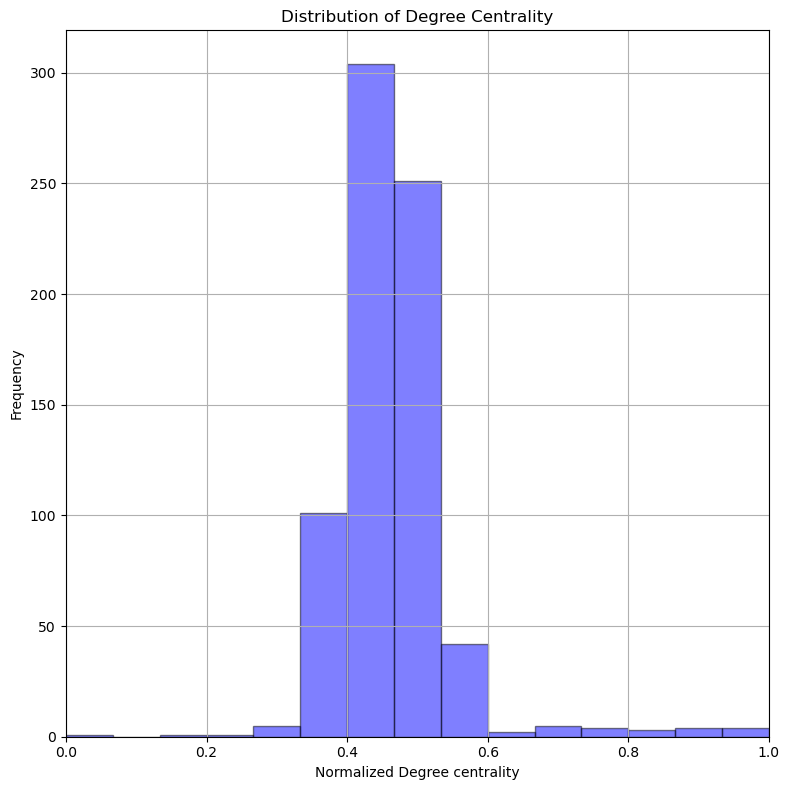

In [1121]:
import torch
import torch_geometric
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn

def set_random_seed(seed=42):
    # Set seed for Python's random module
    random.seed(seed)
    # Set seed for NumPy
    np.random.seed(seed)
    # Set seed for PyTorch (both CPU and GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    # Ensure deterministic behavior on the GPU (if using CUDA)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

class UnsupervisedGNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnsupervisedGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 128)  # Graph Convolution Layer 1
        self.conv2 = pyg_nn.GCNConv(128, 64)  # Graph Convolution Layer 2
        self.fc = nn.Linear(64, out_channels)  # Fully Connected Layer to produce node scores
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Apply first GCN layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # Apply second GCN layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        # Produce the final node scores
        x = self.fc(x)
        return x

# Assuming you already have your data (edge_index, khop matrices for node features)
node_features = torch.tensor(A, dtype=torch.float)
edges = list(g.edges())
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data = Data(x=node_features, edge_index=edge_index)

# Define the model
model = UnsupervisedGNN(in_channels=728, out_channels=1)  # 7280 is the input feature size, adjust accordingly
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

import torch.nn.functional as F

def contrastive_loss_with_diversity(node_embeddings, margin=1.0, threshold=0.3, lambda_diversity=0.1):
    """
    Contrastive loss that encourages similar nodes to be close, different nodes to be far apart,
    and diversity in the embedding space.
    
    Args:
        node_embeddings (torch.Tensor): Tensor containing the node embeddings.
        margin (float): Margin for negative pairs (for contrastive loss).
        threshold (float): Threshold to classify positive and negative pairs based on similarity.
        lambda_diversity (float): Weight for the diversity penalty. A higher value enforces greater diversity.
    
    Returns:
        torch.Tensor: The total contrastive loss with diversity regularization.
    """
    # Cosine similarity between nodes (rows of node_embeddings)
    sim = F.cosine_similarity(node_embeddings.unsqueeze(1), node_embeddings.unsqueeze(0), dim=-1)
    
    # Positive and negative pairs based on similarity threshold
    positive_pairs = (sim > threshold).float()
    negative_pairs = (sim < threshold).float()
    
    # Margin-based loss: maximize similarity of similar nodes, minimize otherwise
    margin_tensor = torch.tensor(0.0).to(node_embeddings.device)
    loss = torch.mean(positive_pairs * (1 - sim) + negative_pairs * torch.max(margin_tensor, sim - margin))
    
    # Diversity Regularization: Penalize embeddings that are too close
    # This computes the pairwise similarity between all node embeddings and sums over the upper triangular part
    diversity_penalty = torch.mean(torch.sum(torch.triu(torch.mm(node_embeddings, node_embeddings.t()), diagonal=1)))
    
    # Total loss with diversity regularization
    total_loss = loss + lambda_diversity * diversity_penalty
    
    return total_loss
    
# Training loop (unsupervised)
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass to compute node embeddings
    output = model(data)
    
    # Calculate a contrastive or ranking-based loss (e.g., cosine similarity)
    loss = contrastive_loss(output)
    
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    node_embeddings = model(data).squeeze()
# node_scores = node_embeddings
# node_scores = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())

embeddings_scaled = torch.log(node_embeddings + 1)  # Add a small constant if embeddings have values near 0
embeddings_scaled = (embeddings_scaled - embeddings_scaled.min()) / (embeddings_scaled.max() - embeddings_scaled.min())
node_scores = embeddings_scaled

node_scores = node_scores.numpy()
top_1_percent_count = int(0.01 * len(node_scores))  # Calculate 1% of the total nodes
top_1_percent_nodes = np.argsort(node_scores)[::-1][:top_1_percent_count]  # Get indices of top 1% nodes
print(top_1_percent_nodes)
np.save("mlc", node_scores)



import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_distribution(c, t, xl, yl):
    plt.figure(figsize=(8, 8))
    plt.hist(c, color='blue', bins=15, fill=True, alpha=0.5, edgecolor='black')
    plt.title(t)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.grid()
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

plot_distribution(node_scores, "Distribution of Degree Centrality", "Normalized Degree centrality", "Frequency")